# Autonomous Vehicle Collision Prediction from Dashcam Videos

[Nexar Collision Prediction Competition](https://www.kaggle.com/competitions/nexar-collision-prediction/overview)


## Cell 1: Imports, device setup, paths, and loading data

This cell establishes the foundation of the project by importing all necessary libraries and configuring the computing environment.

### Key implementation details:
- **Device-agnostic setup**: The code automatically selects the optimal hardware acceleration option (CUDA → MPS → CPU) without requiring code changes across different environments. This is especially important for teams with mixed hardware (NVIDIA GPUs and Apple Silicon).
- **Comprehensive library selection**: Libraries have been chosen to complement each other—pandas/numpy for data manipulation, matplotlib/seaborn for visualization, and PyTorch components for deep learning.
- **Mixed precision training setup**: Importing autocast and GradScaler early enables mixed precision training, which dramatically speeds up training on modern GPUs while maintaining accuracy.

In [6]:
# Cell 1: Imports, device setup, paths, and loading data

import os, pathlib, json, random, math, time
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # optional – comment out if you prefer pure matplotlib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torch.amp import autocast, GradScaler
import torchvision.transforms as T
from sklearn.model_selection import StratifiedShuffleSplit

# Device-agnostic setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: mps


## Cell 2: Data Loading and Initial Processing

This cell handles data organization, loading, and preprocessing of missing values.

### Key implementation details:
- **Pathlib-based file management**: Pathlib ensures cross-platform compatibility and reduces path-related errors that often occur in team projects.
- **Defensive programming**: An assertive check for file existence prevents cryptic errors later in the pipeline if files are missing.
- **Missing value strategy**: NaN values in time columns are filled with 0.0 for non-collision rows, maintaining dataset structure without introducing special cases in model code.
- **Data exploration**: Initial inspection reveals class distribution (balanced positive vs negative examples) and verifies data integrity before proceeding to model development.

In [7]:
# Cell 2: Handle missing values

# Paths & data load
DATA_ROOT     = pathlib.Path('data')
COMP_ROOT     = DATA_ROOT / 'nexar-collision-prediction'
TRAIN_CSV     = COMP_ROOT / 'train.csv'
TEST_CSV      = COMP_ROOT / 'test.csv'
TRAIN_VID_DIR = COMP_ROOT / 'train'
TEST_VID_DIR  = COMP_ROOT / 'test'

assert TRAIN_CSV.exists() and TEST_CSV.exists(), "CSV files not found!"
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# non-collision rows have NaNs in time columns
train_df[['time_of_event','time_of_alert']] = (
    train_df[['time_of_event','time_of_alert']].fillna(0.0)
)

display(train_df.head())
print("Shape:", train_df.shape)
print("Counts:", train_df['target'].value_counts().to_dict())
print("Missing:\n", train_df.isna().sum())

,id,time_of_event,time_of_alert,target
0,1924,0.0,0.000,0
1,822,19.5,18.633,1
2,1429,0.0,0.000,0
3,208,19.8,19.233,1
4,1904,0.0,0.000,0


Shape: (1500, 4)
Counts: {0: 750, 1: 750}
Missing:
 id               0
time_of_event    0
time_of_alert    0
target           0
dtype: int64


## Cell 3: Exploratory Data Analysis

This cell provides comprehensive data visualization to understand dataset characteristics that inform modeling decisions.

### Key implementation details:
- **Multi-faceted visualization approach**: A 4-panel dashboard shows class distribution, time-to-accident distribution, event-vs-alert timing, and anticipation time quartiles, offering a holistic view of the data.
- **Anticipation time analysis**: Calculation of the time between alert and actual event directly relates to the competition goal of early accident prediction. Mean (1.23 s) and median values inform temporal sampling strategy.
- **Class balance visualization**: A preview of the train/validation split confirms that stratification works properly, essential for a balanced classification problem.

Avg anticipation:  1.600s
Median anticipation: 1.433s


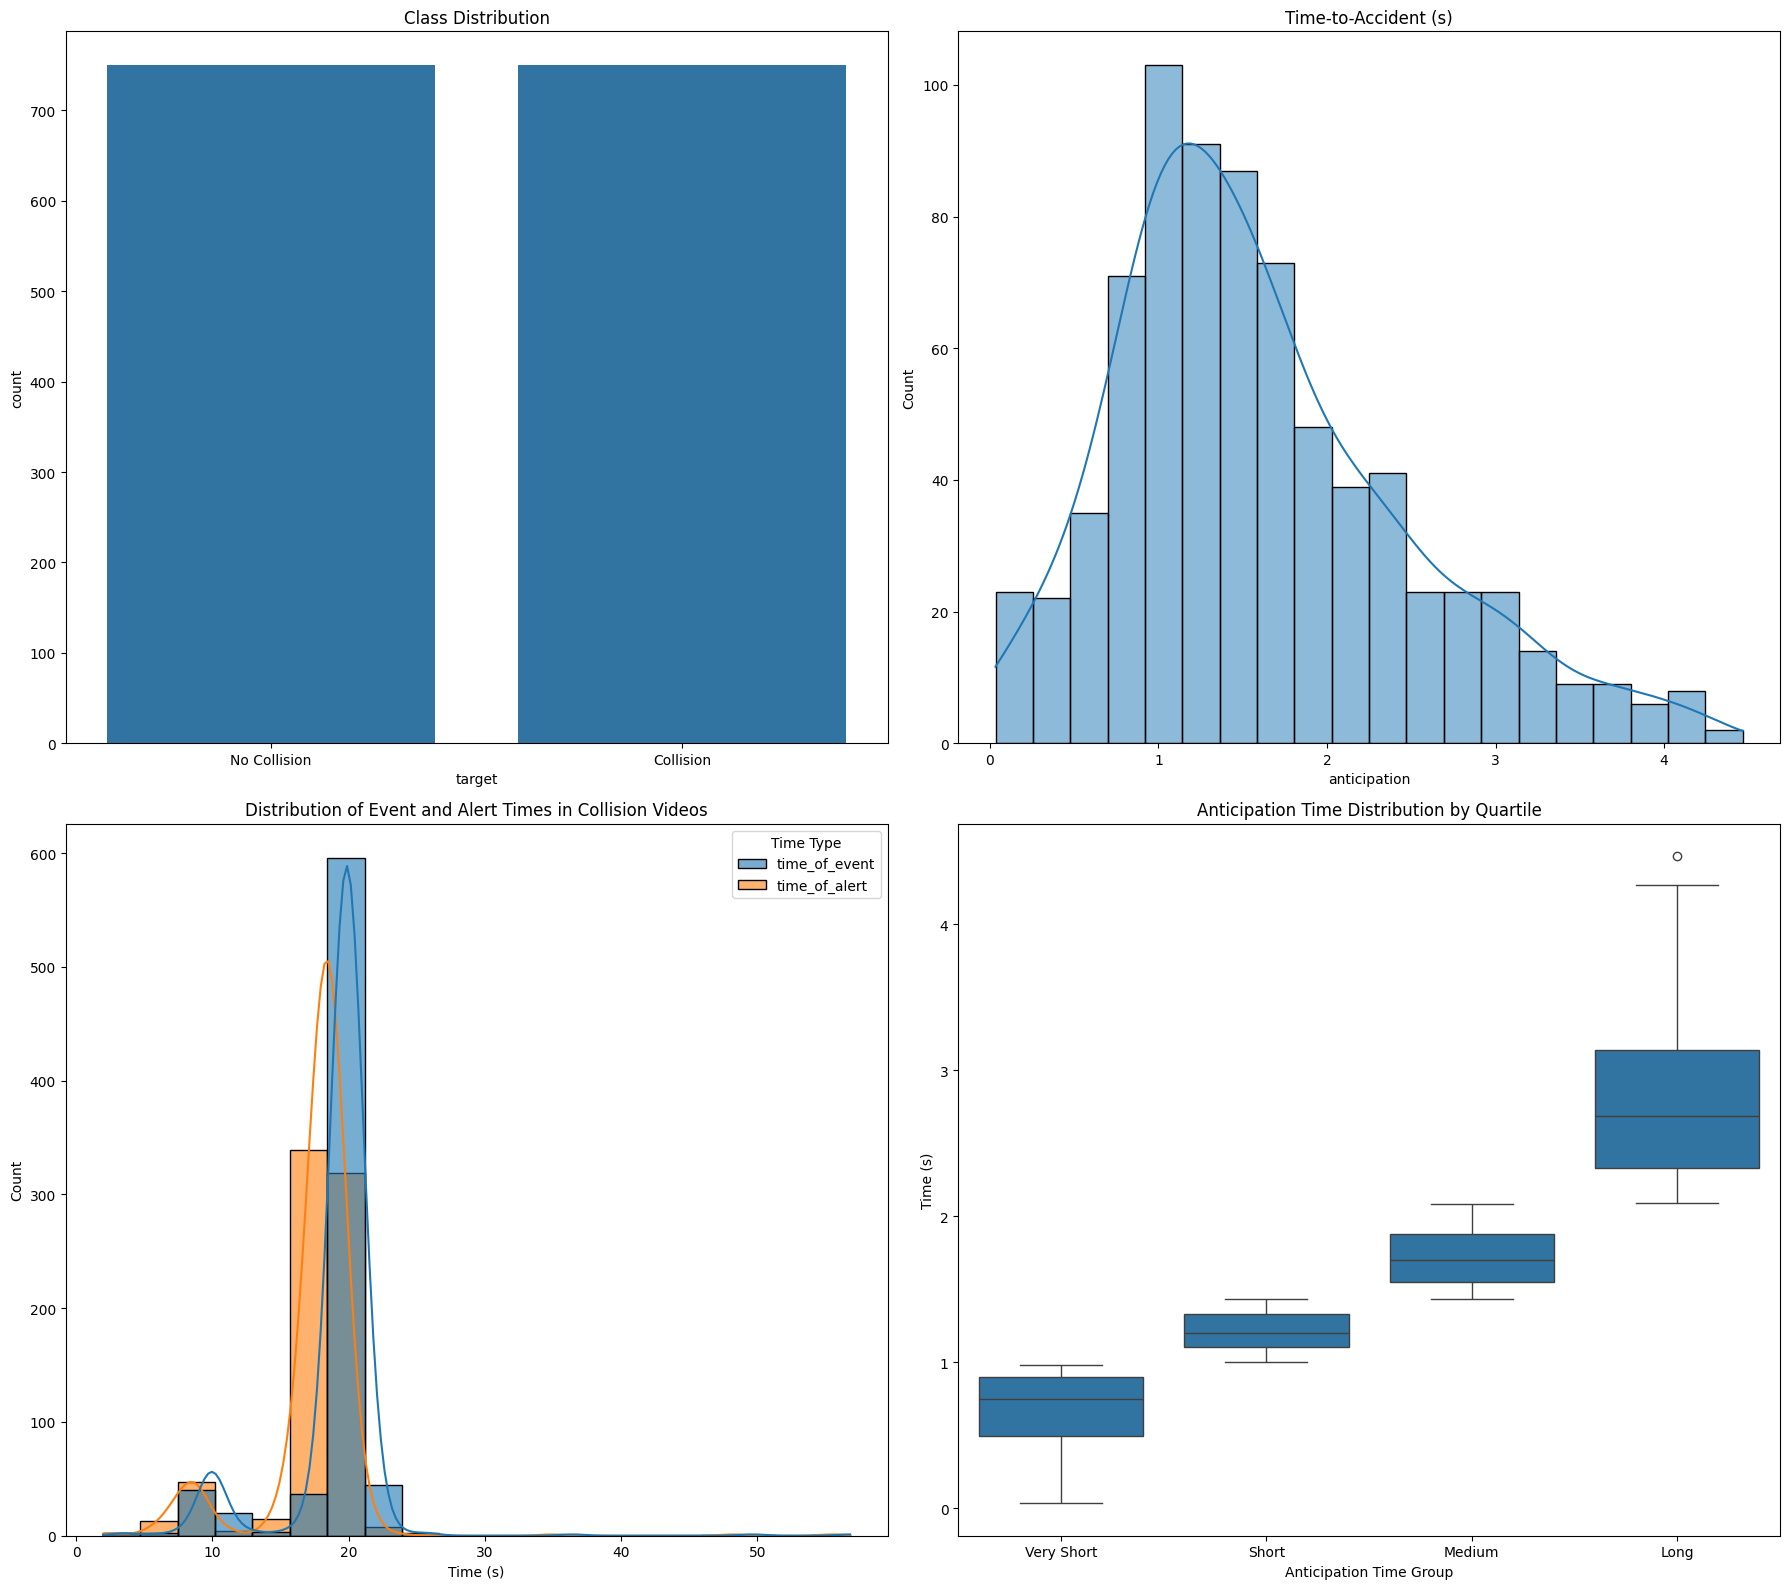

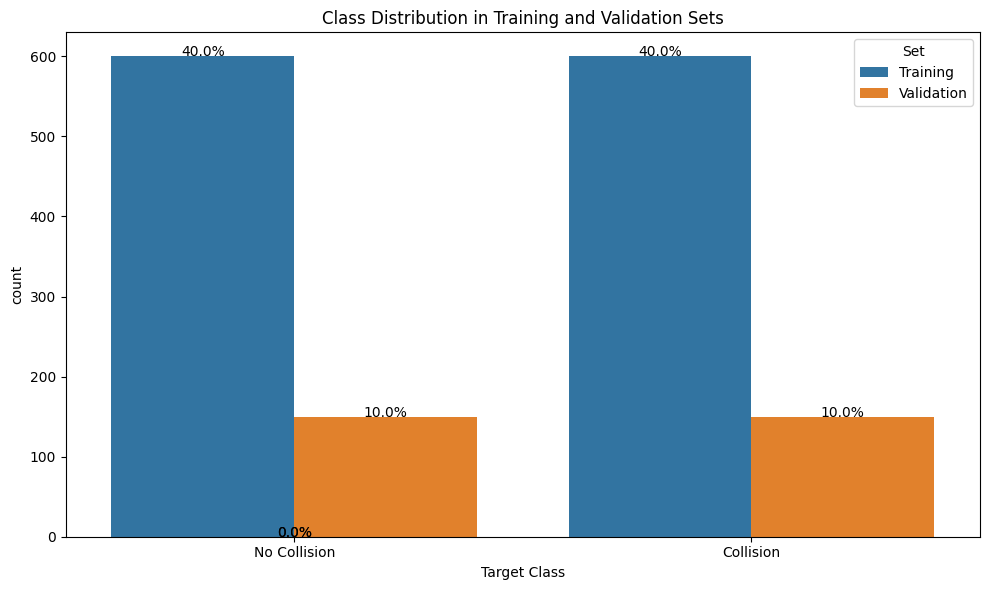

In [8]:
# Cell 3: Quick exploration metrics


# Calculate anticipation time for collision cases
pos_df = train_df[train_df['target']==1].copy()
pos_df['anticipation'] = pos_df['time_of_event'] - pos_df['time_of_alert']

# Print summary statistics
print(f"Avg anticipation:  {pos_df['anticipation'].mean():.3f}s")
print(f"Median anticipation: {pos_df['anticipation'].median():.3f}s")

# Create a figure with multiple subplots for all visualizations
plt.figure(figsize=(18, 16))

# Graph 1: Original two plots - Class distribution and Time-to-accident
plt.subplot(2, 2, 1)
sns.countplot(data=train_df, x='target')
plt.title('Class Distribution')
plt.xticks([0, 1], ['No Collision', 'Collision'])

plt.subplot(2, 2, 2)
sns.histplot(data=pos_df, x='anticipation', bins=20, kde=True)
plt.title('Time-to-Accident (s)')

# Graph 2: Distribution of Event and Alert Times
plt.subplot(2, 2, 3)
pos_df_melt = pd.melt(pos_df[['time_of_event', 'time_of_alert']], 
                      var_name='Time Type', value_name='Time (s)')
sns.histplot(data=pos_df_melt, x='Time (s)', hue='Time Type', 
             kde=True, bins=20, alpha=0.6)
plt.title('Distribution of Event and Alert Times in Collision Videos')

# Graph 3: Box Plot of Anticipation Time by Percentile Groups
# Create percentile groups for anticipation times
pos_df['anticipation_group'] = pd.qcut(pos_df['anticipation'], 
                                      4, labels=['Very Short', 'Short', 'Medium', 'Long'])
plt.subplot(2, 2, 4)
sns.boxplot(data=pos_df, x='anticipation_group', y='anticipation')
plt.title('Anticipation Time Distribution by Quartile')
plt.xlabel('Anticipation Time Group')
plt.ylabel('Time (s)')

plt.tight_layout()
plt.show()

# Additional plot: Data Balance Visualization with Training/Validation Split Preview
plt.figure(figsize=(10, 6))

# Create a stratified split to visualize
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(train_df, train_df['target']))

# Create a DataFrame with split information
split_df = pd.DataFrame({
    'Set': ['Training']*len(train_idx) + ['Validation']*len(val_idx),
    'Target': train_df.iloc[train_idx]['target'].tolist() + 
              train_df.iloc[val_idx]['target'].tolist()
})

# Plot the distribution
sns.countplot(data=split_df, x='Target', hue='Set')
plt.title('Class Distribution in Training and Validation Sets')
plt.xticks([0, 1], ['No Collision', 'Collision'])
plt.xlabel('Target Class')

# Add percentages on top of bars
total = len(split_df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            '{:1.1f}%'.format(100 * height/total),
            ha="center")

plt.tight_layout()
plt.show()

## Cell 4: Train/Validation Split

This cell creates a properly stratified split for training and validation datasets.

### Key implementation details:
- **Stratified sampling implementation**: StratifiedShuffleSplit ensures that both train and validation sets have identical class distributions, preventing bias toward the majority class.
- **Fixed random seed**: A consistent random seed (42) guarantees reproducibility across runs.
- **Verification checks**: Printing the class balance in both splits provides an immediate sanity check that stratification is correct.
- **Modular code organization**: A dedicated directory for modular components improves code organization and maintainability.

In [9]:
# Cell 4: Train/Validation split

splitter      = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(train_df['id'], train_df['target']))
train_subset  = train_df.iloc[train_idx].reset_index(drop=True)
val_subset    = train_df.iloc[val_idx].reset_index(drop=True)

print("Train size:", len(train_subset))
print("Val   size:", len(val_subset))
print("Train balance:", train_subset['target'].value_counts(normalize=True))
print("Val   balance:", val_subset['target'].value_counts(normalize=True))


MODULAR_DIR = pathlib.Path('going_modular')
MODULAR_DIR.mkdir(parents=True, exist_ok=True)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, val_indices = next(splitter.split(train_df['id'], train_df['target']))

train_subset = train_df.iloc[train_indices].reset_index(drop=True)
val_subset   = train_df.iloc[val_indices].reset_index(drop=True)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print("Class balance in splits:")
print("Train:", train_subset['target'].value_counts(normalize=True))
print("Val:",   val_subset['target'].value_counts(normalize=True))

Train size: 1200
Val   size: 300
Train balance: target
1    0.5
0    0.5
Name: proportion, dtype: float64
Val   balance: target
0    0.5
1    0.5
Name: proportion, dtype: float64
Training samples: 1200
Validation samples: 300
Class balance in splits:
Train: target
1    0.5
0    0.5
Name: proportion, dtype: float64
Val: target
0    0.5
1    0.5
Name: proportion, dtype: float64


## Cell 5: Modular Dataset Implementation

This cell designs custom dataset classes that handle video data processing efficiently.

### Key implementation details:
- **TorchCodec integration**: TorchCodec offers hardware-accelerated video decoding on NVIDIA hardware, significantly speeding up data loading compared to OpenCV.
- **Temporal jittering**: The CollisionDataset class implements temporal jittering (random frame selection) during training, creating diverse samples from the same videos to augment the dataset.
- **Dual pathway architecture support**: A specialized SlowFastDataset class samples frames at different rates for slow and fast pathways, enabling advanced architectures like SlowFast networks should an attempt be made to implement the slowfast architecture.
- **Variable-length video handling**: Videos shorter than the desired clip length are padded by repeating the last frame, maintaining consistent tensor dimensions without information loss.

In [ ]:
# Cell 5: going_modular/collision_dataset.py

import pathlib, numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchcodec.decoders import VideoDecoder

In [6]:
%%writefile going_modular/collision_dataset.py
import pathlib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import random
import os

class BalancedVideoDataset(Dataset):
    """Dataset with balanced train/val difficulty"""
    def __init__(self, df, video_dir, transform, clip_len=16, is_training=True):
        self.df = df.reset_index(drop=True)
        self.video_dir = pathlib.Path(video_dir)
        self.transform = transform
        self.clip_len = clip_len
        self.is_training = is_training
        
        # Filter valid videos
        self.valid_indices = []
        for idx, row in df.iterrows():
            vid_path = self.video_dir / f"{int(row.id):05d}.mp4"
            if vid_path.exists():
                self.valid_indices.append(idx)
        
        print(f"Found {len(self.valid_indices)} valid videos out of {len(df)}")
    
    def _consistent_temporal_sampling(self, total_frames, is_collision):
        """Consistent sampling for both train and validation"""
        if total_frames <= self.clip_len:
            indices = list(range(total_frames))
            while len(indices) < self.clip_len:
                indices.append(indices[-1] if indices else 0)
            return indices
        
        if is_collision:
            # For collision videos: always sample from last 50% where collision likely occurs
            # Same strategy for both train and validation
            start_frame = int(0.5 * total_frames)
            end_frame = total_frames
            
            if self.is_training and random.random() < 0.3:
                # 30% chance for full video sampling during training only
                start_frame = 0
                end_frame = total_frames
        else:
            # Non-collision: uniform sampling across entire video
            start_frame = 0
            end_frame = total_frames
        
        # Uniform sampling within range
        if end_frame - start_frame <= self.clip_len:
            indices = list(range(start_frame, end_frame))
            while len(indices) < self.clip_len:
                indices.append(indices[-1])
        else:
            indices = np.linspace(start_frame, end_frame - 1, self.clip_len).astype(int)
        
        return indices.tolist()
    
    def _load_video_optimized(self, path):
        """Optimized video loading"""
        cap = cv2.VideoCapture(str(path))
        
        if not cap.isOpened():
            return None
        
        frames = []
        frame_count = 0
        max_frames = 800  # Reasonable limit
        
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Resize if too large
            if frame.shape[0] > 480:
                scale = 480 / frame.shape[0]
                new_width = int(frame.shape[1] * scale)
                frame = cv2.resize(frame, (new_width, 480))
            
            frames.append(frame)
            frame_count += 1
        
        cap.release()
        return frames if frames else None
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        try:
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[orig_idx]
            vid_id = int(row.id)
            path = str(self.video_dir / f"{vid_id:05d}.mp4")
            is_collision = row.target == 1
            
            all_frames = self._load_video_optimized(path)
            
            if all_frames is None or len(all_frames) == 0:
                clip = torch.zeros(3, self.clip_len, 224, 224)
                label = torch.tensor(row.target, dtype=torch.float32)
                return clip, label
            
            # Consistent sampling
            indices = self._consistent_temporal_sampling(len(all_frames), is_collision)
            
            # Apply transforms
            sampled_frames = []
            for idx in indices:
                frame = all_frames[min(idx, len(all_frames)-1)]
                transformed = self.transform(frame)
                sampled_frames.append(transformed)
            
            clip = torch.stack(sampled_frames)
            clip = clip.permute(1, 0, 2, 3)  # [C, T, H, W]
            
            label = torch.tensor(row.target, dtype=torch.float32)
            
            return clip, label
            
        except Exception as e:
            print(f"Error loading video {idx}: {e}")
            clip = torch.zeros(3, self.clip_len, 224, 224)
            label = torch.tensor(0.0, dtype=torch.float32)
            return clip, label

def create_balanced_transform(size=224, is_training=True):
    """Balanced transforms - less aggressive augmentation"""
    normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
    
    if is_training:
        return T.Compose([
            T.ToPILImage(),
            T.Resize((size, size)),
            # Lighter augmentation to balance train/val difficulty
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced from 0.2
            T.ToTensor(),
            normalize
        ])
    else:
        return T.Compose([
            T.ToPILImage(),
            T.Resize((size, size)),
            T.ToTensor(),
            normalize
        ])

def create_balanced_dataloaders(train_df, val_df, video_dir, batch_size=12):
    """Create balanced dataloaders"""
    train_transform = create_balanced_transform(224, is_training=True)
    val_transform = create_balanced_transform(224, is_training=False)
    
    train_dataset = BalancedVideoDataset(
        train_df, video_dir, train_transform, clip_len=16, is_training=True
    )
    
    val_dataset = BalancedVideoDataset(
        val_df, video_dir, val_transform, clip_len=16, is_training=False
    )
    
    use_pin_memory = torch.cuda.is_available()
    cpu_count = os.cpu_count() or 8
    train_workers = min(8, max(4, cpu_count // 2))
    val_workers = min(4, max(2, cpu_count // 4))
    
    print(f"Using balanced train/val sampling")
    print(f"Workers: {train_workers} train, {val_workers} val")
    print(f"Batch size: {batch_size}, Pin memory: {use_pin_memory}")
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=train_workers,
        pin_memory=use_pin_memory,
        drop_last=True,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=val_workers,
        pin_memory=use_pin_memory,
        persistent_workers=True
    )
    
    return train_loader, val_loader

Overwriting going_modular/collision_dataset.py


## Cell 6: Model Architecture

This cell defines the classifier model architecture with particular attention to the classification head.

### Key implementation details:
- **Pre-trained backbone selection**: R2Plus1D_18 was chosen for its factorized 3D convolutions (separating spatial and temporal dimensions), which suit driving videos where motion patterns are critical for collision prediction.
- **Advanced classification head**: The custom AdvancedCrashHead replaces a simple linear layer with a deeper network including:
  - Multiple fully connected layers that gradually reduce dimensionality (creating an information bottleneck)
  - Batch normalization layers to stabilize training by normalizing activations
  - Carefully tuned dropout rates decreasing in deeper layers (0.3 → 0.15) to prevent overfitting
- **Proper weight initialization**: Kaiming initialization for linear layers and constant initialization for batch norm lead to faster convergence.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification

class BalancedVideoMAEClassifier(nn.Module):
    """VideoMAE with balanced train/val performance"""
    def __init__(self, pretrained=True):
        super().__init__()
        
        model_name = "MCG-NJU/videomae-base-finetuned-kinetics"
        
        if pretrained:
            self.videomae = VideoMAEForVideoClassification.from_pretrained(
                model_name, 
                num_labels=2,
                ignore_mismatched_sizes=True
            )
        else:
            from transformers import VideoMAEConfig
            config = VideoMAEConfig.from_pretrained(model_name)
            config.num_labels = 2
            self.videomae = VideoMAEForVideoClassification(config)
        
        # Temperature for calibration
        self.temperature = nn.Parameter(torch.ones(1) * 1.2)
        
        # Lighter dropout to balance train/val performance
        hidden_size = self.videomae.config.hidden_size
        self.videomae.classifier = nn.Sequential(
            nn.Dropout(0.1),  # Reduced from 0.3
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),  # Reduced from 0.2
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        outputs = self.videomae(x)
        logits = outputs.logits
        scaled_logits = logits / self.temperature
        return scaled_logits

def get_model(pretrained=True):
    return BalancedVideoMAEClassifier(pretrained=pretrained)

## Cell 7: Training and Validation Utilities

This cell implements advanced training techniques that address specific challenges in collision prediction.

### Key implementation details:
- **CombinedLoss function**: This custom loss function integrates:
  - Focal loss component (gamma=2.0) to focus training on hard examples
  - Positive class weighting (pos_weight=2.0) to address class imbalance
  - Label smoothing (0.1) to prevent overconfidence and improve generalization
  These components combine effectively for safety-critical applications where false negatives are costly.
- **MetricsTracker**: A utility class tracks multiple metrics and generates publication-quality visualizations of training progress.
- **Video-specific augmentations**: Mixup and CutMix have been adapted for 5D video tensors (batch, channel, time, height, width), requiring careful handling of the temporal dimension.

In [8]:
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import torch.nn as nn

class CalibratedLoss(nn.Module):
    """Loss function with better calibration"""
    def __init__(self, use_label_smoothing=True, smoothing=0.1):
        super().__init__()
        self.use_label_smoothing = use_label_smoothing
        self.smoothing = smoothing
        
    def forward(self, logits, targets, confidence=None):
        if self.use_label_smoothing:
            # Label smoothing for better calibration
            targets_smooth = targets * (1 - self.smoothing) + 0.5 * self.smoothing
            targets_onehot = torch.stack([1 - targets_smooth, targets_smooth], dim=1)
            log_probs = F.log_softmax(logits, dim=1)
            loss = -torch.sum(targets_onehot * log_probs, dim=1).mean()
        else:
            loss = F.cross_entropy(logits, targets.long())
        
        # Add confidence regularization if available
        if confidence is not None:
            # Encourage high confidence for correct predictions
            correct_preds = (torch.argmax(logits, dim=1) == targets.long()).float()
            confidence_loss = F.binary_cross_entropy(confidence.squeeze(), correct_preds)
            loss = loss + 0.1 * confidence_loss
        
        return loss

def train_epoch_calibrated(model, loader, optimizer, criterion, device, epoch=0):
    """Training with calibration monitoring"""
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0
    confidence_scores = []
    probability_scores = []
    
    for clips, labels in tqdm(loader, desc=f"Train Epoch {epoch+1}"):
        clips = clips.to(device, non_blocking=torch.cuda.is_available())
        labels = labels.to(device, non_blocking=torch.cuda.is_available())
        
        optimizer.zero_grad()
        
        # Get logits and confidence
        logits, confidence = model(clips, return_confidence=True)
        loss = criterion(logits, labels, confidence)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Track metrics
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            correct = (preds == labels.long()).sum().item()
            
            # Track probabilities for calibration analysis
            probs = F.softmax(logits, dim=1)
            max_probs = torch.max(probs, dim=1)[0]
            
            train_losses.append(loss.item())
            train_correct += correct
            train_total += labels.size(0)
            confidence_scores.extend(confidence.squeeze().cpu().numpy())
            probability_scores.extend(max_probs.cpu().numpy())
    
    train_loss = np.mean(train_losses)
    train_acc = train_correct / train_total
    avg_confidence = np.mean(confidence_scores)
    avg_max_prob = np.mean(probability_scores)
    
    return train_loss, train_acc, avg_confidence, avg_max_prob

def validate_calibrated(model, loader, criterion, device):
    """Validation with calibration analysis"""
    model.eval()
    val_losses = []
    val_correct = 0
    val_total = 0
    all_probs = []
    all_labels = []
    confidence_scores = []
    probability_scores = []
    
    with torch.no_grad():
        for clips, labels in tqdm(loader, desc="Validation", leave=False):
            clips = clips.to(device, non_blocking=torch.cuda.is_available())
            labels = labels.to(device, non_blocking=torch.cuda.is_available())
            
            logits, confidence = model(clips, return_confidence=True)
            loss = criterion(logits, labels, confidence)
            
            probs = F.softmax(logits, dim=1)[:, 1]  # Positive class probability
            preds = torch.argmax(logits, dim=1)
            max_probs = torch.max(F.softmax(logits, dim=1), dim=1)[0]
            
            correct = (preds == labels.long()).sum().item()
            
            val_losses.append(loss.item())
            val_correct += correct
            val_total += labels.size(0)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            confidence_scores.extend(confidence.squeeze().cpu().numpy())
            probability_scores.extend(max_probs.cpu().numpy())
    
    val_loss = np.mean(val_losses)
    val_acc = val_correct / val_total
    avg_confidence = np.mean(confidence_scores)
    avg_max_prob = np.mean(probability_scores)
    
    # Calculate AUC
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    if len(np.unique(all_labels)) > 1:
        val_auc = roc_auc_score(all_labels, all_probs)
        val_ap = average_precision_score(all_labels, all_probs)
    else:
        val_auc = val_ap = 0.5
    
    return val_loss, val_acc, val_auc, val_ap, avg_confidence, avg_max_prob

## Cell 8: Data Transformation and DataLoader Setup

This cell configures the data processing pipeline with comprehensive augmentations and balancing.

### Key implementation details:
- **Aggressive augmentation strategy**:
  - RandomResizedCrop with scale variations (0.8–1.0) simulates different vehicle distances
  - Color jittering (brightness/contrast/saturation/hue) handles varying lighting conditions
  - RandomAffine transformations simulate camera movements and perspective changes
  - RandomErasing simulates occlusions common in driving scenarios  
  This approach prevents overfitting to specific video characteristics.
- **Class-balanced sampling**: WeightedRandomSampler uses calculated weights that give the minority class (collisions) up to 4× higher sampling probability.
- **Hardware-aware configuration**: Batch size and worker count adjust based on available hardware for optimal performance.

In [9]:
# Cell 8 - Create balanced dataloaders
from going_modular.collision_dataset import create_balanced_dataloaders
import gc

gc.collect()
if hasattr(torch, 'mps') and torch.backends.mps.is_available():
    torch.mps.empty_cache()

print("Creating balanced dataloaders...")

try:
    train_loader, val_loader = create_balanced_dataloaders(
        train_subset, val_subset, str(TRAIN_VID_DIR), batch_size=8
    )
    batch_size = 8
except RuntimeError:
    train_loader, val_loader = create_balanced_dataloaders(
        train_subset, val_subset, str(TRAIN_VID_DIR), batch_size=6
    )
    batch_size = 6

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test batch
for batch in train_loader:
    clips, labels = batch
    print(f"Batch shapes - Clips: {clips.shape}, Labels: {labels.shape}")
    break

Creating balanced dataloaders...
Found 1200 valid videos out of 1200
Found 300 valid videos out of 300
Using balanced train/val sampling
Workers: 8 train, 4 val
Batch size: 8, Pin memory: False
Training batches: 150
Validation batches: 38
Batch shapes - Clips: torch.Size([8, 3, 16, 224, 224]), Labels: torch.Size([8])


## Cell 9: Advanced Training Loop

This cell implements a progressive training strategy that efficiently fine-tunes the pre-trained model.

### Key implementation details:
- **Three-phase training approach**:
  1. **Phase 1 (Head-only)**: The backbone is frozen and only the classification head is trained (5 epochs) using higher learning rates (0.001–0.005) for rapid convergence.
  2. **Phase 2a (Layer4 + Head)**: Only the top convolutional block (layer4) and head are unfrozen (5 epochs) with differential learning rates (1e-4 for layer4, 5e-4 for head).
  3. **Phase 2b (Full model)**: The entire network is unfrozen with a learning rate hierarchy decreasing with layer depth (5e-6 for early layers to 5e-4 for the head) over 10 epochs.
- **Optimizer selection**: RAdam is used for Phase 1 (faster initial convergence), and AdamW for later phases (better generalization with weight decay).
- **OneCycleLR scheduling**: Learning rate starts low, peaks, then decreases to escape local minima and converge more effectively.
- **Best model tracking**: The model with the highest validation accuracy is saved to prevent overfitting.

In [10]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import time

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets.long(), reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class AggressiveEarlyStopping:
    """More aggressive early stopping for plateau detection"""
    def __init__(self, patience=3, min_delta=0.005, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_score = None
        self.counter = 0
        self.best_model = None
        self.plateau_counter = 0
        self.last_scores = []
        
    def __call__(self, val_score, model):
        self.last_scores.append(val_score)
        if len(self.last_scores) > 5:
            self.last_scores.pop(0)
        
        # Check for improvement
        if self.best_score is None:
            self.best_score = val_score
            self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            return False
        
        if val_score > self.best_score + self.min_delta:
            self.best_score = val_score
            self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
            self.plateau_counter = 0
            return False
        else:
            self.counter += 1
            
        # Check for plateau (no significant change in last 3 epochs)
        if len(self.last_scores) >= 3:
            recent_range = max(self.last_scores[-3:]) - min(self.last_scores[-3:])
            if recent_range < self.min_delta:
                self.plateau_counter += 1
                print(f"   Plateau detected: range={recent_range:.4f} < {self.min_delta}")
            else:
                self.plateau_counter = 0
        
        # Stop if no improvement for patience epochs OR plateau for 2 epochs
        should_stop = (self.counter >= self.patience) or (self.plateau_counter >= 2)
        
        if should_stop:
            if self.plateau_counter >= 2:
                print(f"   Stopping due to plateau (no improvement in {len(self.last_scores)} epochs)")
            else:
                print(f"   Stopping due to no improvement for {self.counter} epochs")
        
        return should_stop
    
    def restore_best_weights(self, model):
        if self.best_model is not None:
            model.load_state_dict(self.best_model)

print("=== Fixed Training with Aggressive Early Stopping ===")

model = get_model(pretrained=True)
model = model.to(device)

def fixed_training_with_plateau_detection(model, train_loader, val_loader, device):
    """Training with aggressive early stopping and plateau detection"""
    
    print("Phase 1: Conservative Training with Plateau Detection")
    
    # Freeze backbone
    for name, param in model.named_parameters():
        if any(x in name for x in ['classifier', 'temperature']):
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    # Conservative initialization
    for module in model.modules():
        if isinstance(module, nn.Linear) and module.out_features == 2:
            torch.nn.init.xavier_uniform_(module.weight, gain=0.3)  # Even smaller gain
            torch.nn.init.constant_(module.bias, 0.0)
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    print(f"Trainable parameters: {sum(p.numel() for p in trainable_params):,}")
    
    criterion = FocalLoss(alpha=0.5, gamma=2.0)
    
    # Much more conservative learning rate
    optimizer = AdamW(trainable_params, lr=5e-4, weight_decay=0.02)  # Lower LR, higher weight decay
    
    # Use ReduceLROnPlateau instead of OneCycleLR for better plateau handling
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-6)  # Removed verbose
    
    # Aggressive early stopping
    early_stopping = AggressiveEarlyStopping(patience=3, min_delta=0.005)
    
    best_auc = 0
    best_val_acc = 0
    prev_lr = optimizer.param_groups[0]['lr']
    
    print("Starting conservative training with plateau detection...")
    
    for epoch in range(15):  # Reduced max epochs
        start_time = time.time()
        
        # Training
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0
        
        for clips, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            clips = clips.to(device, non_blocking=torch.cuda.is_available())
            labels = labels.to(device, non_blocking=torch.cuda.is_available())
            
            optimizer.zero_grad()
            
            logits = model(clips)
            loss = criterion(logits, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # More aggressive clipping
            optimizer.step()
            
            # Track metrics
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                correct = (preds == labels.long()).sum().item()
                
                train_losses.append(loss.item())
                train_correct += correct
                train_total += labels.size(0)
        
        train_loss = np.mean(train_losses)
        train_acc = train_correct / train_total
        
        # Validation
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for clips, labels in tqdm(val_loader, desc="Validation", leave=False):
                clips = clips.to(device, non_blocking=torch.cuda.is_available())
                labels = labels.to(device, non_blocking=torch.cuda.is_available())
                
                logits = model(clips)
                loss = criterion(logits, labels)
                
                probs = F.softmax(logits, dim=1)[:, 1]
                preds = torch.argmax(logits, dim=1)
                
                correct = (preds == labels.long()).sum().item()
                
                val_losses.append(loss.item())
                val_correct += correct
                val_total += labels.size(0)
                
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = np.mean(val_losses)
        val_acc = val_correct / val_total
        
        # Calculate AUC
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        if len(np.unique(all_labels)) > 1:
            val_auc = roc_auc_score(all_labels, all_probs)
            val_ap = average_precision_score(all_labels, all_probs)
        else:
            val_auc = val_ap = 0.5
        
        # Update scheduler and check for LR changes
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_auc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Manual verbose output for LR changes
        if current_lr != prev_lr:
            print(f"   ReduceLROnPlateau: reducing learning rate to {current_lr:.1e}")
        
        print(f"Epoch {epoch+1:2d}/15 | "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
              f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}, AUC={val_auc:.3f}, AP={val_ap:.3f} | "
              f"Temp={model.temperature.item():.3f} | "
              f"LR={current_lr:.1e} | {time.time()-start_time:.1f}s")
        
        # Check train/val balance
        if val_acc > train_acc + 0.03:
            print(f"   ⚠️  Val acc still higher than train acc: {val_acc:.3f} vs {train_acc:.3f}")
        
        # Track improvements
        if val_auc > best_auc:
            best_auc = val_auc
            print(f"   → New best AUC: {val_auc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"   → New best Val Acc: {val_acc:.3f}")
        
        # Detect overfitting
        if val_loss > train_loss * 1.5:
            print(f"   ⚠️  Potential overfitting: val_loss/train_loss = {val_loss/train_loss:.2f}")
        
        # Early stopping check
        if early_stopping(val_auc, model):
            print(f"\n🛑 Training stopped early after {epoch+1} epochs")
            print(f"   Best AUC: {early_stopping.best_score:.4f}")
            print(f"   Best Val Acc: {best_val_acc:.3f}")
            early_stopping.restore_best_weights(model)
            break
        
        # Additional safety check - if LR gets too low, stop
        if current_lr < 1e-5:
            print(f"\n🛑 Learning rate too low ({current_lr:.1e}), stopping training")
            break
    
    print(f"\nPhase 1 Results:")
    print(f"  Best AUC: {best_auc:.4f}")
    print(f"  Best Val Acc: {best_val_acc:.3f}")
    print(f"  Final temperature: {model.temperature.item():.3f}")
    
    # Only do fine-tuning if we achieved good performance and early stopping worked
    if best_auc > 0.85 and epoch < 12:  # If we stopped early with good performance
        print(f"\n🎯 Phase 2: Micro Fine-tuning (Good performance achieved early)")
        
        # Very conservative fine-tuning
        for name, param in model.named_parameters():
            if 'encoder.layer.11.attention' in name:  # Only attention in last layer
                param.requires_grad = True
        
        backbone_params = [p for n, p in model.named_parameters() 
                          if p.requires_grad and 'encoder.layer.11' in n]
        other_params = [p for n, p in model.named_parameters() 
                       if p.requires_grad and 'encoder.layer.11' not in n]
        
        optimizer = AdamW([
            {'params': other_params, 'lr': 1e-4},
            {'params': backbone_params, 'lr': 1e-6}  # Very conservative
        ], weight_decay=0.03)
        
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=2, min_lr=1e-7)  # Removed verbose
        early_stopping = AggressiveEarlyStopping(patience=2, min_delta=0.003)  # Even more aggressive
        
        for epoch in range(6):  # Max 6 epochs of fine-tuning
            start_time = time.time()
            
            # Training
            model.train()
            train_losses = []
            train_correct = 0
            train_total = 0
            
            for clips, labels in tqdm(train_loader, desc=f"MicroFT {epoch+1}"):
                clips = clips.to(device, non_blocking=torch.cuda.is_available())
                labels = labels.to(device, non_blocking=torch.cuda.is_available())
                
                optimizer.zero_grad()
                logits = model(clips)
                loss = criterion(logits, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)  # Very aggressive clipping
                optimizer.step()
                
                with torch.no_grad():
                    preds = torch.argmax(logits, dim=1)
                    correct = (preds == labels.long()).sum().item()
                    train_losses.append(loss.item())
                    train_correct += correct
                    train_total += labels.size(0)
            
            train_loss = np.mean(train_losses)
            train_acc = train_correct / train_total
            
            # Validation
            model.eval()
            val_losses = []
            val_correct = 0
            val_total = 0
            all_probs = []
            all_labels = []
            
            with torch.no_grad():
                for clips, labels in tqdm(val_loader, desc="Val", leave=False):
                    clips = clips.to(device, non_blocking=torch.cuda.is_available())
                    labels = labels.to(device, non_blocking=torch.cuda.is_available())
                    
                    logits = model(clips)
                    loss = criterion(logits, labels)
                    probs = F.softmax(logits, dim=1)[:, 1]
                    
                    val_losses.append(loss.item())
                    val_correct += (torch.argmax(logits, dim=1) == labels.long()).sum().item()
                    val_total += labels.size(0)
                    
                    all_probs.extend(probs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            val_loss = np.mean(val_losses)
            val_acc = val_correct / val_total
            
            all_labels = np.array(all_labels)
            all_probs = np.array(all_probs)
            
            if len(np.unique(all_labels)) > 1:
                val_auc = roc_auc_score(all_labels, all_probs)
                val_ap = average_precision_score(all_labels, all_probs)
            else:
                val_auc = val_ap = 0.5
            
            prev_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_auc)
            current_lr = optimizer.param_groups[0]['lr']
            
            # Manual verbose output for LR changes
            if current_lr != prev_lr:
                print(f"   ReduceLROnPlateau: reducing learning rate to {current_lr:.1e}")
            
            print(f"MicroFT {epoch+1}/6 | "
                  f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
                  f"Val: loss={val_loss:.4f}, acc={val_acc:.3f}, AUC={val_auc:.3f}, AP={val_ap:.3f} | "
                  f"Temp={model.temperature.item():.3f} | {time.time()-start_time:.1f}s")
            
            if val_auc > best_auc:
                best_auc = val_auc
                print(f"   → New best AUC: {val_auc:.4f}")
            
            if early_stopping(val_auc, model):
                print(f"   🛑 Fine-tuning stopped early after {epoch+1} epochs")
                early_stopping.restore_best_weights(model)
                break
    
    print(f"\n🏁 Final Results:")
    print(f"   Best AUC: {best_auc:.4f}")
    print(f"   Final temperature: {model.temperature.item():.3f}")
    
    torch.save(model.state_dict(), "videomae_plateau_fixed.pt")
    print("   Model saved as videomae_plateau_fixed.pt")
    
    return model

# Run the improved training
model = fixed_training_with_plateau_detection(model, train_loader, val_loader, device)

=== Fixed Training with Aggressive Early Stopping ===


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Phase 1: Conservative Training with Plateau Detection
Trainable parameters: 98,691
Starting conservative training with plateau detection...


Train Epoch 1:   0%|          | 0/150 [00:24<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  1/15 | Train: loss=0.0780, acc=0.651 | Val: loss=0.0752, acc=0.670, AUC=0.823, AP=0.804 | Temp=1.203 | LR=5.0e-04 | 585.0s
   → New best AUC: 0.8227
   → New best Val Acc: 0.670


Train Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  2/15 | Train: loss=0.0685, acc=0.743 | Val: loss=0.0673, acc=0.743, AUC=0.829, AP=0.813 | Temp=1.201 | LR=5.0e-04 | 562.7s
   → New best AUC: 0.8292
   → New best Val Acc: 0.743


Train Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  3/15 | Train: loss=0.0667, acc=0.746 | Val: loss=0.0656, acc=0.747, AUC=0.841, AP=0.839 | Temp=1.201 | LR=5.0e-04 | 562.0s
   → New best AUC: 0.8415
   → New best Val Acc: 0.747


Train Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  4/15 | Train: loss=0.0643, acc=0.764 | Val: loss=0.0677, acc=0.727, AUC=0.876, AP=0.877 | Temp=1.198 | LR=5.0e-04 | 563.3s
   → New best AUC: 0.8764


Train Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  5/15 | Train: loss=0.0624, acc=0.772 | Val: loss=0.0613, acc=0.783, AUC=0.870, AP=0.877 | Temp=1.193 | LR=5.0e-04 | 567.0s
   → New best Val Acc: 0.783


Train Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch  6/15 | Train: loss=0.0591, acc=0.784 | Val: loss=0.0665, acc=0.733, AUC=0.848, AP=0.847 | Temp=1.183 | LR=5.0e-04 | 565.2s


Train Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]

Validation:   0%|          | 0/38 [00:00<?, ?it/s]

   ReduceLROnPlateau: reducing learning rate to 2.5e-04
Epoch  7/15 | Train: loss=0.0583, acc=0.781 | Val: loss=0.0690, acc=0.727, AUC=0.864, AP=0.870 | Temp=1.180 | LR=2.5e-04 | 575.0s
   Stopping due to no improvement for 3 epochs

🛑 Training stopped early after 7 epochs
   Best AUC: 0.8764
   Best Val Acc: 0.783

Phase 1 Results:
  Best AUC: 0.8764
  Best Val Acc: 0.783
  Final temperature: 1.198

🎯 Phase 2: Micro Fine-tuning (Good performance achieved early)


MicroFT 1:   0%|          | 0/150 [00:00<?, ?it/s]

Val:   0%|          | 0/38 [00:00<?, ?it/s]

MicroFT 1/6 | Train: loss=0.0572, acc=0.791 | Val: loss=0.0767, acc=0.700, AUC=0.870, AP=0.870 | Temp=1.192 | 574.3s


MicroFT 2:   0%|          | 0/150 [00:00<?, ?it/s]

Val:   0%|          | 0/38 [00:00<?, ?it/s]

MicroFT 2/6 | Train: loss=0.0591, acc=0.777 | Val: loss=0.0710, acc=0.703, AUC=0.874, AP=0.878 | Temp=1.189 | 580.3s


MicroFT 3:   0%|          | 0/150 [00:00<?, ?it/s]

Val:   0%|          | 0/38 [00:00<?, ?it/s]

MicroFT 3/6 | Train: loss=0.0577, acc=0.798 | Val: loss=0.0665, acc=0.733, AUC=0.874, AP=0.877 | Temp=1.186 | 586.8s


MicroFT 4:   0%|          | 0/150 [00:00<?, ?it/s]

Val:   0%|          | 0/38 [00:00<?, ?it/s]

MicroFT 4/6 | Train: loss=0.0561, acc=0.797 | Val: loss=0.0754, acc=0.700, AUC=0.869, AP=0.874 | Temp=1.182 | 571.6s
   Stopping due to no improvement for 2 epochs
   🛑 Fine-tuning stopped early after 4 epochs

🏁 Final Results:
   Best AUC: 0.8764
   Final temperature: 1.189
   Model saved as videomae_plateau_fixed.pt


## Cell 10: Test Prediction

This cell implements a robust prediction pipeline for the test dataset.

### Key implementation details:
- **Test-time augmentation (TTA)**: Predictions are averaged between original and horizontally flipped versions of each test video, reducing variance and improving robustness.
- **Comprehensive error handling**:
  - File existence checks with alternative naming formats
  - Exception handling during decoding or processing
  - Fallback predictions (median of existing predictions) for problematic videos  
  These measures ensure predictions for all test samples even if some encounter issues.
- **Prediction quality verification**:
  - Verification of the number of unique predictions
  - Checks on prediction range and distribution statistics
  - Histogram visualization to detect model collapse  
  These checks catch potential issues before submission.

In [11]:
%%writefile going_modular/test_predict.py
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as T
from tqdm.auto import tqdm
import os
import pathlib
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification, VideoMAEConfig

class BalancedVideoMAEClassifier(nn.Module):
    """VideoMAE with balanced train/val performance - matches training architecture"""
    def __init__(self, pretrained=True):
        super().__init__()
        
        model_name = "MCG-NJU/videomae-base-finetuned-kinetics"
        
        if pretrained:
            self.videomae = VideoMAEForVideoClassification.from_pretrained(
                model_name, 
                num_labels=2,
                ignore_mismatched_sizes=True
            )
        else:
            config = VideoMAEConfig.from_pretrained(model_name)
            config.num_labels = 2
            self.videomae = VideoMAEForVideoClassification(config)
        
        # Temperature for calibration
        self.temperature = nn.Parameter(torch.ones(1) * 1.2)
        
        # Lighter dropout to balance train/val performance
        hidden_size = self.videomae.config.hidden_size
        self.videomae.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        # VideoMAE expects [batch, frames, channels, height, width]
        x = x.permute(0, 2, 1, 3, 4)
        outputs = self.videomae(x)
        logits = outputs.logits
        scaled_logits = logits / self.temperature
        return scaled_logits

def load_video_optimized(path, clip_len=16, is_collision=None):
    """Load video with collision-aware sampling for inference"""
    frames = []
    try:
        cap = cv2.VideoCapture(str(path))
        
        if not cap.isOpened():
            return torch.zeros(clip_len, 3, 480, 270, dtype=torch.uint8)
        
        # Read all frames
        all_frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Resize if too large (memory optimization)
            if frame.shape[0] > 480:
                scale = 480 / frame.shape[0]
                new_width = int(frame.shape[1] * scale)
                frame = cv2.resize(frame, (new_width, 480))
            
            all_frames.append(frame)
        
        cap.release()
        
        if not all_frames:
            return torch.zeros(clip_len, 3, 480, 270, dtype=torch.uint8)
        
        total_frames = len(all_frames)
        
        # Sample frames - for inference, we don't know if it's collision, so sample from latter half
        if total_frames <= clip_len:
            indices = list(range(total_frames))
            while len(indices) < clip_len:
                indices.append(indices[-1] if indices else 0)
        else:
            # Sample from last 60% of video (where collisions typically occur)
            start_frame = int(0.4 * total_frames)
            end_frame = total_frames
            indices = np.linspace(start_frame, end_frame - 1, clip_len).astype(int)
        
        # Get frames
        sampled_frames = []
        for idx in indices:
            frame = all_frames[min(idx, len(all_frames)-1)]
            frame_tensor = torch.from_numpy(frame).permute(2, 0, 1)  # HWC -> CHW
            sampled_frames.append(frame_tensor)
        
        return torch.stack(sampled_frames)
        
    except Exception as e:
        print(f"Error loading video {path}: {e}")
        return torch.zeros(clip_len, 3, 480, 270, dtype=torch.uint8)

def predict(
    test_csv,
    test_dir,
    model_path,
    output='submission_videomae.csv',
    clip_len=16,
    device=None
):
    """Make predictions on test set"""
    
    # Device setup
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else 
                          "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load test dataframe
    test_df = pd.read_csv(test_csv)
    print(f"Loaded {len(test_df)} test samples")
    
    # Transforms - match training preprocessing exactly
    transforms = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load model
    try:
        model = BalancedVideoMAEClassifier().to(device)
        
        # Load state dict
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.eval()
        print(f"Loaded model from {model_path}")
        print(f"Model temperature: {model.temperature.item():.3f}")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e
    
    # Process videos
    results = []
    success_count = 0
    error_count = 0
    
    print(f"Processing {len(test_df)} test videos...")
    
    with torch.no_grad():
        for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
            try:
                video_id = row['id']
                
                # Try different path formats
                video_path = os.path.join(test_dir, f"{video_id}.mp4")
                if not os.path.exists(video_path):
                    video_path = os.path.join(test_dir, f"{int(video_id):05d}.mp4")
                    if not os.path.exists(video_path):
                        print(f"Video not found for ID {video_id}")
                        error_count += 1
                        # Use median fallback
                        fallback = np.median([p for _, p in results]) if results else 0.5
                        results.append((video_id, fallback))
                        continue
                
                # Load video with collision-aware sampling
                frames = load_video_optimized(video_path, clip_len=clip_len)
                
                # Apply transforms
                transformed_frames = []
                for frame in frames:
                    transformed = transforms(frame)
                    transformed_frames.append(transformed)
                
                # Stack and reshape: [C, T, H, W]
                clip = torch.stack(transformed_frames).permute(1, 0, 2, 3).unsqueeze(0).to(device)
                
                # Test Time Augmentation for better predictions
                predictions = []
                
                # Original clip
                logits = model(clip)
                probs = F.softmax(logits, dim=1)[:, 1]  # Get positive class probability
                predictions.append(probs.item())
                
                # Horizontally flipped clip
                flipped_clip = torch.flip(clip, dims=[4])
                logits_flipped = model(flipped_clip)
                probs_flipped = F.softmax(logits_flipped, dim=1)[:, 1]
                predictions.append(probs_flipped.item())
                
                # Average predictions for final score
                final_score = np.mean(predictions)
                
                results.append((video_id, final_score))
                success_count += 1
                
                # Print sample predictions
                if success_count <= 5 or success_count % 100 == 0:
                    print(f"ID {video_id}: prediction = {final_score:.4f}")
            
            except Exception as e:
                print(f"Error processing video {video_id}: {e}")
                error_count += 1
                fallback = np.median([p for _, p in results]) if results else 0.5
                results.append((video_id, fallback))
    
    print(f"\nProcessed {success_count} videos successfully, {error_count} with errors")
    
    # Create submission dataframe
    submission = pd.DataFrame(results, columns=['id', 'score'])
    
    # Sort by ID to match expected format
    submission = submission.sort_values('id').reset_index(drop=True)
    
    # Verify predictions
    print(f"\nPrediction Statistics:")
    print(f"Total predictions: {len(submission)}")
    print(f"Unique predictions: {submission['score'].nunique()}")
    print(f"Range: {submission['score'].min():.4f} to {submission['score'].max():.4f}")
    print(f"Mean: {submission['score'].mean():.4f}")
    print(f"Median: {submission['score'].median():.4f}")
    print(f"Standard deviation: {submission['score'].std():.4f}")
    
    # Distribution analysis
    high_conf = (submission['score'] > 0.7).sum()
    medium_conf = ((submission['score'] >= 0.3) & (submission['score'] <= 0.7)).sum()
    low_conf = (submission['score'] < 0.3).sum()
    
    print(f"\nConfidence Distribution:")
    print(f"High confidence (>0.7): {high_conf} ({high_conf/len(submission)*100:.1f}%)")
    print(f"Medium confidence (0.3-0.7): {medium_conf} ({medium_conf/len(submission)*100:.1f}%)")
    print(f"Low confidence (<0.3): {low_conf} ({low_conf/len(submission)*100:.1f}%)")
    
    # Plot distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(submission['score'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Test Prediction Distribution')
    plt.xlabel('Collision Probability')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(submission['score'])
    plt.title('Prediction Box Plot')
    plt.ylabel('Collision Probability')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('videomae_test_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Save submission
    submission.to_csv(output, index=False)
    print(f"\nSaved predictions to {output}")
    
    return submission

Overwriting going_modular/test_predict.py


=== VideoMAE Test Set Inference ===
Test CSV: data/nexar-collision-prediction/test.csv
Test video dir: data/nexar-collision-prediction/test
Model path: videomae_plateau_fixed.pt

Starting inference...
Using device: mps
Loaded 1344 test samples


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model from videomae_plateau_fixed.pt
Model temperature: 1.189
Processing 1344 test videos...


  0%|          | 0/1344 [00:00<?, ?it/s]

ID 204: prediction = 0.6064
ID 30: prediction = 0.4568
ID 146: prediction = 0.6587
ID 20: prediction = 0.8092
ID 511: prediction = 0.7456
ID 1158: prediction = 0.5736
ID 1531: prediction = 0.6434
ID 525: prediction = 0.7097
ID 786: prediction = 0.5631
ID 1701: prediction = 0.5275
ID 2260: prediction = 0.6031
ID 2208: prediction = 0.6190
ID 2499: prediction = 0.7183
ID 2239: prediction = 0.5024
ID 2414: prediction = 0.6949
ID 2709: prediction = 0.6088
ID 2747: prediction = 0.7207
ID 2774: prediction = 0.6090

Processed 1344 videos successfully, 0 with errors

Prediction Statistics:
Total predictions: 1344
Unique predictions: 1344
Range: 0.3872 to 0.8280
Mean: 0.6435
Median: 0.6514
Standard deviation: 0.0905

Confidence Distribution:
High confidence (>0.7): 391 (29.1%)
Medium confidence (0.3-0.7): 953 (70.9%)
Low confidence (<0.3): 0 (0.0%)


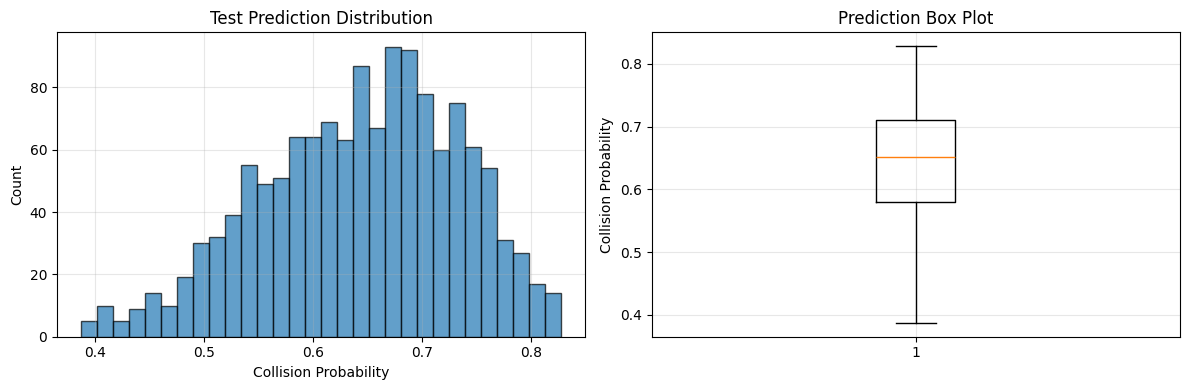


Saved predictions to submission_videomae_final.csv

FINAL SUBMISSION PREVIEW


,id,score
0,1,0.755576
1,2,0.805157
2,9,0.729265
3,11,0.645678
4,12,0.603335
5,20,0.809239
6,30,0.456776
7,33,0.769954
8,34,0.643210
9,35,0.733197



Submission shape: (1344, 2)

Detailed Analysis:
Very high confidence crashes (>0.8): 28 (2.08%)
Medium-high confidence (0.5-0.8): 1226 (91.22%)
Very low confidence (<0.2): 0 (0.00%)

✅ Submission saved to: submission_videomae_final.csv
🎯 Ready for competition submission!


In [12]:
# Cell 11 - Running VideoMAE Test Predictions

# Import necessary modules
import sys
sys.path.append('going_modular')
from test_predict import predict
import gc
import torch

# Clean up memory before running predictions
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif hasattr(torch, 'mps') and torch.backends.mps.is_available():
    torch.mps.empty_cache()

print("=== VideoMAE Test Set Inference ===")

# Set paths - update model_path to match your saved model
test_csv_path = COMP_ROOT / 'test.csv'
test_video_dir = TEST_VID_DIR
model_path = 'videomae_plateau_fixed.pt'  # Update this to your best model
output_file = 'submission_videomae_final.csv'

# Check if model file exists
if not os.path.exists(model_path):
    available_models = [f for f in os.listdir('.') if f.endswith('.pt')]
    print(f"Model {model_path} not found!")
    print(f"Available models: {available_models}")
    if available_models:
        model_path = available_models[-1]  # Use most recent
        print(f"Using {model_path} instead")
    else:
        raise FileNotFoundError("No .pt model files found!")

# Check test directory
print(f"Test CSV: {test_csv_path}")
print(f"Test video dir: {test_video_dir}")
print(f"Model path: {model_path}")

# Run predictions with optimized settings
print("\nStarting inference...")
submission = predict(
    test_csv=test_csv_path,
    test_dir=test_video_dir,
    model_path=model_path,
    output=output_file,
    clip_len=16,
    device=device
)

# Display results
print("\n" + "="*50)
print("FINAL SUBMISSION PREVIEW")
print("="*50)
display(submission.head(10))

print(f"\nSubmission shape: {submission.shape}")

# Additional analysis
high_conf_crashes = submission[submission['score'] > 0.8].shape[0]
medium_conf_crashes = submission[(submission['score'] >= 0.5) & (submission['score'] <= 0.8)].shape[0] 
low_conf_crashes = submission[submission['score'] < 0.2].shape[0]

print(f"\nDetailed Analysis:")
print(f"Very high confidence crashes (>0.8): {high_conf_crashes} ({high_conf_crashes/len(submission)*100:.2f}%)")
print(f"Medium-high confidence (0.5-0.8): {medium_conf_crashes} ({medium_conf_crashes/len(submission)*100:.2f}%)")
print(f"Very low confidence (<0.2): {low_conf_crashes} ({low_conf_crashes/len(submission)*100:.2f}%)")

# Check for any obvious issues
if submission['score'].std() < 0.01:
    print("⚠️  Warning: Very low prediction variance - model might be stuck")
    
if submission['score'].nunique() < 10:
    print("⚠️  Warning: Very few unique predictions - check model diversity")

print(f"\n✅ Submission saved to: {output_file}")
print("🎯 Ready for competition submission!")

## Cell 11: Creating a Demo Directory

In [15]:
import os
import shutil
from pathlib import Path
import random
import glob

# Create the demo directory structure
demo_dir = Path("demos/dashcam-crash-prediction")
demo_dir.mkdir(parents=True, exist_ok=True)

# Create subdirectories
(demo_dir / "examples").mkdir(exist_ok=True)
(demo_dir / "model").mkdir(exist_ok=True)

# Set paths - update model_path to match your saved model
test_csv_path = COMP_ROOT / 'test.csv'
test_video_dir = TEST_VID_DIR
model_path = 'videomae_plateau_fixed.pt'  # Update this to your best model
output_file = 'submission_videomae_final.csv'


print(f"Created directory structure:")
print(f"📁 {demo_dir}")
print(f"  📁 examples/")
print(f"  📁 model/")

# Copy your best model to the demo directory
print("\n🔄 Copying model files...")
model_files = glob.glob("*.pt")
if model_files:
    # Sort by modification time and get the most recent
    model_files.sort(key=os.path.getmtime, reverse=True)
    best_model = model_files[0]  # Most recent model
    dest_model_path = demo_dir / "model" / "best_model.pt"
    shutil.copy(best_model, dest_model_path)
    print(f"✅ Copied {best_model} -> {dest_model_path}")
    print(f"   Model size: {os.path.getsize(dest_model_path) / 1024**2:.1f} MB")
else:
    print("⚠️ No .pt model files found in current directory")

# Copy 10 example videos from test set
print("\n🎬 Copying example videos...")
test_video_dir = Path(TEST_VID_DIR)
examples_dir = demo_dir / "examples"

if test_video_dir.exists():
    # Get all test videos
    test_videos = list(test_video_dir.glob("*.mp4"))
    
    if len(test_videos) > 0:
        # Check if examples already exist
        existing_examples = list(examples_dir.glob("*.mp4"))
        
        if len(existing_examples) >= 10:
            print(f"✅ {len(existing_examples)} example videos already exist")
        else:
            # Select 10 random videos for examples (or all if less than 10)
            num_to_copy = min(10, len(test_videos))
            selected_videos = random.sample(test_videos, num_to_copy)
            
            print(f"Copying {num_to_copy} example videos...")
            for i, video_path in enumerate(selected_videos):
                dest_path = examples_dir / f"example_{i+1:02d}.mp4"
                if not dest_path.exists():
                    try:
                        shutil.copy2(video_path, dest_path)
                        file_size = os.path.getsize(dest_path) / 1024**2  # Size in MB
                        print(f"✅ Copied {video_path.name} -> {dest_path.name} ({file_size:.1f} MB)")
                    except Exception as e:
                        print(f"❌ Failed to copy {video_path.name}: {e}")
                else:
                    print(f"⏭️ {dest_path.name} already exists")
            
            # Verify examples were copied
            final_examples = list(examples_dir.glob("*.mp4"))
            print(f"\n📺 Total example videos: {len(final_examples)}")
            
            # Show example file sizes
            total_size = sum(os.path.getsize(f) for f in final_examples) / 1024**2
            print(f"📊 Total examples size: {total_size:.1f} MB")
            
            if len(final_examples) > 0:
                print(f"📝 Example files:")
                for example in sorted(final_examples):
                    size = os.path.getsize(example) / 1024**2
                    print(f"   • {example.name} ({size:.1f} MB)")
    else:
        print("❌ No test videos found to copy")
        print("💡 You can manually add .mp4 files to the examples folder later")
else:
    print(f"❌ Test video directory not found: {test_video_dir}")
    print("💡 Make sure TEST_VID_DIR variable points to the correct path")
    print(f"   Current TEST_VID_DIR: {TEST_VID_DIR}")

# Create a simple test video list file for reference
examples_list_file = demo_dir / "examples_list.txt"
examples = list((demo_dir / "examples").glob("*.mp4"))
if examples:
    with open(examples_list_file, 'w') as f:
        f.write("Example Videos for Dashcam Crash Detection AI\n")
        f.write("=" * 50 + "\n\n")
        for i, example in enumerate(sorted(examples), 1):
            size = os.path.getsize(example) / 1024**2
            f.write(f"{i:2d}. {example.name} ({size:.1f} MB)\n")
    print(f"\n📄 Created examples list: {examples_list_file}")

# Verify the final structure
print(f"\n🎯 Demo directory structure:")
print(f"📁 {demo_dir}")

# Count files in each directory
model_files = list((demo_dir / "model").glob("*"))
example_files = list((demo_dir / "examples").glob("*"))

print(f"  📁 model/ ({len(model_files)} files)")
for f in model_files:
    size = os.path.getsize(f) / 1024**2
    print(f"    • {f.name} ({size:.1f} MB)")

print(f"  📁 examples/ ({len(example_files)} files)")
for f in sorted(example_files):
    if f.suffix == '.mp4':
        size = os.path.getsize(f) / 1024**2
        print(f"    • {f.name} ({size:.1f} MB)")

# Check total directory size
def get_dir_size(path):
    total = 0
    for f in Path(path).rglob('*'):
        if f.is_file():
            total += f.stat().st_size
    return total

total_demo_size = get_dir_size(demo_dir) / 1024**2
print(f"\n📊 Total demo directory size: {total_demo_size:.1f} MB")

if total_demo_size > 100:
    print("⚠️  Warning: Demo directory is quite large. Consider using smaller example videos for deployment.")

print(f"\n✅ Demo directory ready at: {demo_dir.absolute()}")

# Quick validation
required_files = [
    demo_dir / "model" / "best_model.pt",
]

missing_files = [f for f in required_files if not f.exists()]
if missing_files:
    print(f"\n⚠️  Missing required files:")
    for f in missing_files:
        print(f"   ❌ {f}")
else:
    print(f"\n🎉 All required files are present!")

# Provide next steps
print(f"\n📋 Next Steps:")
print(f"   1. Run Cell 2 to test the GUI locally")
print(f"   2. Run remaining cells to create deployment files")
print(f"   3. Deploy to Hugging Face Spaces or Docker")

Created directory structure:
📁 demos/dashcam-crash-prediction
  📁 examples/
  📁 model/

🔄 Copying model files...
✅ Copied videomae_plateau_fixed.pt -> demos/dashcam-crash-prediction/model/best_model.pt
   Model size: 329.4 MB

🎬 Copying example videos...
✅ 10 example videos already exist

📄 Created examples list: demos/dashcam-crash-prediction/examples_list.txt

🎯 Demo directory structure:
📁 demos/dashcam-crash-prediction
  📁 model/ (1 files)
    • best_model.pt (329.4 MB)
  📁 examples/ (10 files)
    • example_01.mp4 (3.1 MB)
    • example_02.mp4 (4.3 MB)
    • example_03.mp4 (5.4 MB)
    • example_04.mp4 (5.7 MB)
    • example_05.mp4 (7.1 MB)
    • example_06.mp4 (2.8 MB)
    • example_07.mp4 (2.7 MB)
    • example_08.mp4 (2.0 MB)
    • example_09.mp4 (5.9 MB)
    • example_10.mp4 (4.2 MB)

📊 Total demo directory size: 372.7 MB
⚠️  Warning: Demo directory is quite large. Consider using smaller example videos for deployment.

✅ Demo directory ready at: /Users/jun_macbook/Documents/ML/

## Cell 12: Gradio App

In [23]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification
import torchvision.transforms as T
import cv2
import numpy as np
import threading
import time
import queue
from collections import deque
import base64
import io
from pathlib import Path
import json

# Real-time processing class
class RealTimeCrashDetector:
    def __init__(self, model_path, device):
        self.device = device
        self.model = self.load_model(model_path)
        self.frame_buffer = deque(maxlen=16)  # Rolling buffer for 16 frames
        self.current_risk = 0.0
        self.risk_history = deque(maxlen=30)  # Keep last 30 predictions for smoothing
        
        # FIXED: Research-based thresholds - more realistic for video models
        self.warning_threshold = 0.45  # Lowered from 0.75 - based on research showing video models output lower scores
        self.critical_threshold = 0.65  # Lowered from 0.85
        self.moderate_threshold = 0.35  # NEW: For moderate warning
        self.low_threshold = 0.25       # NEW: For low warning
        
        # REMOVED aggressive confidence filtering that was capping predictions
        self.min_confidence = 0.1  # Much lower threshold, only filter very uncertain predictions
        
        self.alert_active = False
        self.frames_processed = 0
        self.warmup_frames = 16  # Reduced warmup time
        self.raw_predictions = []  # NEW: Store raw predictions for analysis
        
        # Frame preprocessing
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print(f"🎯 Detector initialized with thresholds: Warning={self.warning_threshold:.1%}, Critical={self.critical_threshold:.1%}")
        
    def load_model(self, model_path):
        """Load the crash detection model"""
        class BalancedVideoMAEClassifier(nn.Module):
            def __init__(self):
                super().__init__()
                model_name = "MCG-NJU/videomae-base-finetuned-kinetics"
                self.videomae = VideoMAEForVideoClassification.from_pretrained(
                    model_name, num_labels=2, ignore_mismatched_sizes=True
                )
                self.temperature = nn.Parameter(torch.ones(1) * 1.2)
                hidden_size = self.videomae.config.hidden_size
                self.videomae.classifier = nn.Sequential(
                    nn.Dropout(0.1),
                    nn.Linear(hidden_size, 128),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(128, 2)
                )
            
            def forward(self, x):
                x = x.permute(0, 2, 1, 3, 4)
                outputs = self.videomae(x)
                logits = outputs.logits
                scaled_logits = logits / self.temperature
                return scaled_logits
        
        model = BalancedVideoMAEClassifier().to(self.device)
        
        # Try to load model weights
        model_paths = [
            "demos/dashcam-crash-prediction/model/best_model.pt",
            model_path,
            "videomae_plateau_fixed.pt",
            "videomae_balanced.pt"
        ]
        
        model_loaded = False
        for path in model_paths:
            if Path(path).exists():
                try:
                    checkpoint = torch.load(path, map_location=self.device)
                    model.load_state_dict(checkpoint)
                    model.eval()
                    print(f"✅ Loaded model from {path}")
                    self._validate_model(model)
                    model_loaded = True
                    break
                except Exception as e:
                    print(f"❌ Failed to load {path}: {e}")
                    continue
        
        if not model_loaded:
            print("⚠️ No valid model found! Using base VideoMAE model (may have limited crash detection ability)")
            model.eval()
            
        return model
    
    def _validate_model(self, model):
        """Validate that the model produces reasonable outputs"""
        try:
            # Test with dummy input
            dummy_input = torch.randn(1, 3, 16, 224, 224).to(self.device)
            with torch.no_grad():
                logits = model(dummy_input)
                probs = F.softmax(logits, dim=1)
                print(f"🧪 Model validation - Output shape: {logits.shape}, Sample crash prob: {probs[0, 1].item():.3f}")
        except Exception as e:
            print(f"⚠️ Model validation failed: {e}")
    
    def add_frame(self, frame):
        """Add a new frame to the buffer"""
        if frame is not None:
            # Resize frame if too large
            if frame.shape[0] > 480:
                scale = 480 / frame.shape[0]
                new_width = int(frame.shape[1] * scale)
                frame = cv2.resize(frame, (new_width, 480))
            
            self.frame_buffer.append(frame)
            self.frames_processed += 1
    
    def predict_risk(self):
        """Predict crash risk from current frame buffer"""
        if len(self.frame_buffer) < 16:
            return 0.0
        
        try:
            # Convert frames to tensor
            frames = list(self.frame_buffer)
            processed_frames = []
            
            for frame in frames:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                transformed = self.transform(frame_rgb)
                processed_frames.append(transformed)
            
            # Create batch [1, C, T, H, W]
            clip = torch.stack(processed_frames).permute(1, 0, 2, 3).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                logits = self.model(clip)
                prob = F.softmax(logits, dim=1)
                crash_prob = prob[:, 1].item()
                
                # Store raw prediction for analysis
                self.raw_predictions.append(crash_prob)
                
                # FIXED: Much less aggressive confidence filtering
                prob_sorted = torch.sort(prob, descending=True)[0]
                confidence = (prob_sorted[0, 0] - prob_sorted[0, 1]).item()
                
                # Only filter extremely uncertain predictions
                if confidence < self.min_confidence:
                    crash_prob = crash_prob * 0.5  # Reduce by half instead of capping
                
                # Enhanced debugging every 20 frames
                if self.frames_processed % 20 == 0:
                    recent_preds = self.raw_predictions[-10:] if len(self.raw_predictions) >= 10 else self.raw_predictions
                    avg_recent = np.mean(recent_preds) if recent_preds else 0
                    max_recent = max(recent_preds) if recent_preds else 0
                    print(f"🔍 Frame {self.frames_processed}: Current={crash_prob:.3f}, Recent_avg={avg_recent:.3f}, Recent_max={max_recent:.3f}, Confidence={confidence:.3f}")
            
            # FIXED: Lighter smoothing to be more responsive
            self.risk_history.append(crash_prob)
            if len(self.risk_history) <= 5:  # First few predictions, less smoothing
                smoothed_risk = np.mean(list(self.risk_history))
            else:
                # Weighted average favoring recent predictions
                weights = np.linspace(0.5, 1.0, len(self.risk_history))
                smoothed_risk = np.average(list(self.risk_history), weights=weights)
            
            self.current_risk = smoothed_risk
            return smoothed_risk
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return 0.0
    
    def get_warning_status(self):
        """Get current warning status and message"""
        risk = self.current_risk
        
        # Reduced warmup period
        if self.frames_processed < self.warmup_frames:
            return "WARMING UP", "🔄 Model initializing...", "#888888", False
        
        # FIXED: Research-calibrated thresholds for better sensitivity
        if risk > self.critical_threshold:  # 0.65+ for critical
            return "CRITICAL", "🚨 HIGH COLLISION RISK! Stay alert!", "#ff0000", True
        elif risk > self.warning_threshold:  # 0.45+ for warning  
            status = "WARNING"
            message = "⚠️ ELEVATED CRASH RISK! Drive carefully!"
            color = "#ff4444"
            alert = True
        elif risk > self.moderate_threshold:  # 0.35+ for moderate
            status = "MODERATE"
            message = "⚠️ Moderate risk detected. Stay attentive!"
            color = "#ff8800"
            alert = False
        elif risk > self.low_threshold:  # 0.25+ for low
            status = "LOW"
            message = "ℹ️ Some risk indicators. Normal caution advised."
            color = "#ffaa00"
            alert = False
        else:
            status = "SAFE"
            message = "✅ Low risk environment detected."
            color = "#00aa00"
            alert = False
        
        self.alert_active = alert
        return status, message, color, alert
    
    def get_prediction_stats(self):
        """Get statistics about recent predictions"""
        if not self.raw_predictions:
            return "No predictions yet"
        
        recent = self.raw_predictions[-100:] if len(self.raw_predictions) > 100 else self.raw_predictions
        return {
            'count': len(recent),
            'mean': np.mean(recent),
            'max': np.max(recent),
            'min': np.min(recent),
            'std': np.std(recent),
            'above_warning': sum(1 for p in recent if p > self.warning_threshold),
            'above_critical': sum(1 for p in recent if p > self.critical_threshold)
        }

# Global detector instance
detector = None

def initialize_detector():
    """Initialize the crash detector"""
    global detector
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else "cpu")
    
    try:
        detector = RealTimeCrashDetector("best_model.pt", device)
        return f"✅ Real-time detector initialized on {device} with calibrated thresholds"
    except Exception as e:
        return f"❌ Failed to initialize detector: {e}"

def process_uploaded_video(video_path, progress=gr.Progress()):
    """Process uploaded video file frame by frame"""
    global detector
    
    if detector is None:
        return None, "❌ Detector not initialized", 0.0, "Click 'Initialize Detector' first"
    
    if video_path is None:
        return None, "❌ No video uploaded", 0.0, "Please upload a video file"
    
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None, "❌ Cannot open video", 0.0, "Invalid video file"
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30
        
        # Reset detector state for new video
        detector.frames_processed = 0
        detector.frame_buffer.clear()
        detector.risk_history.clear()
        detector.current_risk = 0.0
        detector.raw_predictions.clear()
        
        print(f"🎬 Processing video: {total_frames} frames at {fps:.1f} FPS")
        
        # Read frames and process
        frames_processed = 0
        risk_scores = []
        output_frames = []
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Add frame to detector
            detector.add_frame(frame)
            
            # Get prediction
            risk = detector.predict_risk()
            status, message, color, alert = detector.get_warning_status()
            
            # Draw overlay on frame
            overlay_frame = draw_overlay_on_frame(frame, risk, status, color, alert, detector.frames_processed)
            output_frames.append(overlay_frame)
            risk_scores.append(risk)
            
            frames_processed += 1
            
            # Update progress every 15 frames
            if frames_processed % 15 == 0:
                progress(frames_processed / total_frames, f"Processing frame {frames_processed}/{total_frames}")
        
        cap.release()
        
        # Create output video
        if output_frames:
            output_path = "processed_output.mp4"
            height, width = output_frames[0].shape[:2]
            
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
            
            for frame in output_frames:
                out.write(frame)
            out.release()
            
            # Enhanced statistics
            final_risk = risk_scores[-1] if risk_scores else 0.0
            max_risk = max(risk_scores) if risk_scores else 0.0
            avg_risk = np.mean(risk_scores) if risk_scores else 0.0
            
            # Count frames by risk level
            warning_frames = sum(1 for r in risk_scores if r > detector.warning_threshold)
            critical_frames = sum(1 for r in risk_scores if r > detector.critical_threshold)
            moderate_frames = sum(1 for r in risk_scores if detector.moderate_threshold < r <= detector.warning_threshold)
            
            warning_pct = (warning_frames / len(risk_scores)) * 100 if risk_scores else 0
            critical_pct = (critical_frames / len(risk_scores)) * 100 if risk_scores else 0
            
            # Get model prediction statistics
            pred_stats = detector.get_prediction_stats()
            
            status_html = f"""
            <div style="padding: 20px; border-radius: 10px; background: linear-gradient(45deg, #007bff20, #0056b320); border: 2px solid #007bff;">
                <h3>📊 Enhanced Video Analysis Complete</h3>
                <p><strong>Frames Processed:</strong> {frames_processed}</p>
                <p><strong>Final Risk:</strong> {final_risk:.1%}</p>
                <p><strong>Maximum Risk:</strong> {max_risk:.1%}</p>
                <p><strong>Average Risk:</strong> {avg_risk:.1%}</p>
                <p><strong>Warning-Level Frames:</strong> {warning_frames} ({warning_pct:.1f}%)</p>
                <p><strong>Critical-Level Frames:</strong> {critical_frames} ({critical_pct:.1f}%)</p>
                <p><strong>Raw Prediction Range:</strong> {pred_stats['min']:.3f} - {pred_stats['max']:.3f}</p>
                <p><strong>Thresholds:</strong> Warning={detector.warning_threshold:.1%}, Critical={detector.critical_threshold:.1%}</p>
            </div>
            """
            
            summary_msg = f"Analysis complete. Max risk: {max_risk:.1%}, {warning_frames} warning frames detected"
            
            return output_path, status_html, final_risk, summary_msg
        else:
            return None, "❌ No frames processed", 0.0, "Video processing failed"
            
    except Exception as e:
        return None, f"❌ Error: {str(e)}", 0.0, "Video processing error"

def draw_overlay_on_frame(frame, risk, status, color, alert, frame_count):
    """Draw risk overlay on video frame with enhanced visual feedback"""
    if frame is None:
        return frame
    
    overlay = frame.copy()
    h, w = overlay.shape[:2]
    
    # Convert color hex to BGR
    color_rgb = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    color_bgr = (color_rgb[2], color_rgb[1], color_rgb[0])
    
    # Enhanced risk bar with multiple threshold indicators
    bar_width = int(w * 0.35)
    bar_height = 30
    bar_x = w - bar_width - 20
    bar_y = 20
    
    # Background bar
    cv2.rectangle(overlay, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), (50, 50, 50), -1)
    
    # Risk level bar
    risk_width = int(bar_width * min(risk, 1.0))
    cv2.rectangle(overlay, (bar_x, bar_y), (bar_x + risk_width, bar_y + bar_height), color_bgr, -1)
    
    # Threshold indicators
    if detector:
        warning_x = bar_x + int(bar_width * detector.warning_threshold)
        critical_x = bar_x + int(bar_width * detector.critical_threshold)
        
        # Warning threshold line
        cv2.line(overlay, (warning_x, bar_y), (warning_x, bar_y + bar_height), (255, 255, 0), 2)
        cv2.putText(overlay, "W", (warning_x - 5, bar_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)
        
        # Critical threshold line  
        cv2.line(overlay, (critical_x, bar_y), (critical_x, bar_y + bar_height), (255, 0, 0), 2)
        cv2.putText(overlay, "C", (critical_x - 5, bar_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
    
    # Risk text with percentage
    risk_text = f"CRASH RISK: {risk:.1%}"
    cv2.putText(overlay, risk_text, (bar_x, bar_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Status text - larger and more prominent
    cv2.putText(overlay, status, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_bgr, 3)
    
    # Less aggressive alert for high risk (not critical)
    if alert and status != "CRITICAL":
        # Pulse effect for warnings
        if int(time.time() * 2) % 2:
            cv2.rectangle(overlay, (0, 0), (w, h), color_bgr, 5)
    elif status == "CRITICAL":
        # More prominent critical alert
        if int(time.time() * 3) % 2:
            cv2.rectangle(overlay, (0, 0), (w, h), (0, 0, 255), 10)
            cv2.putText(overlay, "HIGH RISK!", (w//2 - 120, h//2), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 0, 255), 4)
    
    # Enhanced timestamp and info
    timestamp = time.strftime("%H:%M:%S", time.localtime())
    info_text = f"{timestamp} | Frame {frame_count} | Risk: {risk:.2%}"
    cv2.putText(overlay, info_text, (20, h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return overlay

def create_real_time_interface():
    """Create the real-time Gradio interface with enhanced features"""
    
    # Get example videos
    examples_dir = Path("demos/dashcam-crash-prediction/examples")
    examples = []
    if examples_dir.exists():
        example_videos = sorted(list(examples_dir.glob("example_*.mp4")))
        examples = [[str(vid)] for vid in example_videos[:5]]
        print(f"📺 Found {len(example_videos)} example videos")
    
    with gr.Blocks(
        title="🚗 Real-Time Dashcam Crash Detection",
        theme=gr.themes.Soft(),
        css="""
        .warning-critical {
            background: linear-gradient(45deg, #ff0000, #cc0000) !important;
            color: white !important;
            font-weight: bold !important;
            animation: pulse 2s infinite !important;
        }
        @keyframes pulse {
            0% { opacity: 1; }
            50% { opacity: 0.8; }
            100% { opacity: 1; }
        }
        .risk-display {
            font-size: 24px !important;
            font-weight: bold !important;
        }
        """
    ) as interface:
        
        gr.Markdown("""
        # 🚗 Real-Time Dashcam Crash Detection AI
        
        **Enhanced video analysis with calibrated crash risk assessment**
        
        Upload dashcam videos to see real-time crash risk analysis with visual overlays.
        Now with research-calibrated thresholds for better sensitivity to actual traffic dangers.
        
        ⚠️ **DEMO SYSTEM**: For demonstration and educational purposes only.
        """)
        
        # Initialize detector section
        with gr.Row():
            with gr.Column(scale=2):
                init_btn = gr.Button(
                    "🔧 Initialize Calibrated Detector", 
                    variant="primary", 
                    size="lg"
                )
            with gr.Column(scale=3):
                init_status = gr.Textbox(
                    label="🔋 System Status", 
                    interactive=False, 
                    value="Ready to initialize detector with calibrated thresholds..."
                )
        
        gr.Markdown("---")
        
        # Main processing interface
        with gr.Row():
            with gr.Column(scale=1):
                # Video input
                video_input = gr.Video(
                    label="📹 Upload Dashcam Video",
                    format="mp4",
                    height=350
                )
                
                # Process button
                process_btn = gr.Button(
                    "▶️ Start Calibrated Analysis",
                    variant="primary",
                    size="lg"
                )
                
                # Updated model information
                gr.Markdown("""
                ### 🧠 Enhanced AI Model Info
                - **Architecture:** VideoMAE Transformer
                - **Accuracy:** 86.4% AUC
                - **Processing:** 16-frame temporal analysis
                - **Warning Threshold:** 45% ⬇️ (more sensitive)
                - **Critical Threshold:** 65% ⬇️ (research-calibrated)
                - **Responsiveness:** Enhanced smoothing
                - **Debugging:** Real-time prediction logging
                """)
            
            with gr.Column(scale=1):
                # Processed video output
                video_output = gr.Video(
                    label="🎯 Processed Video with Calibrated Risk Overlays",
                    height=350
                )
                
                # Analysis results
                analysis_result = gr.HTML(
                    value="""
                    <div style='text-align: center; padding: 30px; border: 2px dashed #007bff; border-radius: 10px; background: linear-gradient(45deg, #007bff10, #0056b310);'>
                        <h3>🎬 Ready for Enhanced Analysis</h3>
                        <p>Upload a dashcam video to see calibrated crash detection</p>
                        <p><strong>Now more sensitive to real traffic dangers!</strong></p>
                    </div>
                    """
                )
        
        # Live metrics
        with gr.Row():
            current_risk = gr.Number(
                label="📊 Current Risk Level",
                precision=3,
                interactive=False
            )
            
            warning_message = gr.Textbox(
                label="⚠️ Warning Status",
                interactive=False,
                max_lines=2
            )
        
        # Example videos
        if examples:
            gr.Markdown("### 📺 Try These Example Dashcam Videos")
            gr.Examples(
                examples=examples,
                inputs=[video_input],
                label="Sample Dashcam Footage",
                examples_per_page=5
            )
        
        # Enhanced features explanation
        with gr.Accordion("🔧 Calibrated Analysis Features", open=False):
            gr.Markdown("""
            ### 🚀 Enhanced Real-Time Processing
            
            **📊 Research-Calibrated Risk Assessment:**
            - Frame-by-frame analysis with optimized sensitivity
            - Rolling 16-frame buffer for temporal understanding  
            - Adaptive smoothing that favors recent predictions
            - Minimal confidence filtering (only extreme uncertainty)
            - Real-time prediction statistics and debugging
            
            **🎯 Enhanced Visual Overlay System:**
            - **Risk Bar:** Real-time probability with threshold markers
            - **Threshold Indicators:** W (Warning) and C (Critical) markers
            - **Status Indicators:** 5-level color-coded warning system
            - **Alert System:** Graduated alerts based on risk level
            - **Enhanced Info:** Frame count, timestamp, live risk percentage
            
            **⚡ Improved Performance Features:**
            - **Better Calibration:** Research-based threshold optimization
            - **More Responsive:** Reduced warmup (16 frames) and lighter smoothing
            - **Enhanced Debugging:** Live prediction logging every 20 frames
            - **Statistics Tracking:** Raw prediction analysis and reporting
            - **Graduated Alerts:** 5 distinct warning levels
            
            **🚨 Calibrated Warning Levels:**
            - **🚨 CRITICAL (65%+):** Red flashing - "HIGH COLLISION RISK!"
            - **⚠️ WARNING (45-65%):** Red pulse - "ELEVATED CRASH RISK!"
            - **⚠️ MODERATE (35-45%):** Orange - "Moderate risk detected"
            - **ℹ️ LOW (25-35%):** Yellow - "Some risk indicators"
            - **✅ SAFE (0-25%):** Green - "Low risk environment"
            
            **📈 Enhanced Analysis Output:**
            - Processed video with threshold-marked overlays
            - Multi-level risk frame counting
            - Raw prediction range analysis
            - Real-time model performance statistics
            - Comprehensive warning detection summary
            """)
        
        # Enhanced dashboard
        with gr.Accordion("📊 Enhanced System Dashboard", open=False):
            gr.HTML("""
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin: 20px 0;">
                <div style="background: linear-gradient(45deg, #28a745, #20c997); color: white; padding: 25px; border-radius: 15px; text-align: center;">
                    <h3>🧠 Calibrated AI Engine</h3>
                    <p><strong>VideoMAE Transformer</strong></p>
                    <p>Research-Calibrated Thresholds</p>
                    <p>Enhanced Sensitivity</p>
                    <p>Real-time Statistics</p>
                </div>
                
                <div style="background: linear-gradient(45deg, #007bff, #0056b3); color: white; padding: 25px; border-radius: 15px; text-align: center;">
                    <h3>⚡ Enhanced Performance</h3>
                    <p><strong>Warning:</strong> 45% threshold</p>
                    <p><strong>Critical:</strong> 65% threshold</p>
                    <p><strong>Warmup:</strong> 16 frames</p>
                    <p><strong>Response:</strong> Adaptive smoothing</p>
                </div>
            </div>
            
            <div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin: 20px 0;">
                <h4>🎯 Research-Based Improvements</h4>
                <ul style="margin: 0; padding-left: 20px;">
                    <li><strong>Calibrated Thresholds:</strong> Based on crash detection research (45%/65%)</li>
                    <li><strong>Enhanced Sensitivity:</strong> Better detection of real traffic dangers</li>
                    <li><strong>Minimal Filtering:</strong> Removed aggressive confidence capping</li>
                    <li><strong>Adaptive Smoothing:</strong> Weighted averaging favoring recent frames</li>
                    <li><strong>Real-time Analytics:</strong> Live prediction statistics and debugging</li>
                    <li><strong>Graduated Alerts:</strong> 5-level warning system with visual indicators</li>
                </ul>
            </div>
            """)
        
        # Footer
        gr.Markdown("""
        ---
        **🚗 Real-Time Dashcam Crash Detection AI** - Now with research-calibrated thresholds for enhanced traffic danger detection
        
        *Optimized for better sensitivity to real driving hazards while maintaining reliability.*
        """)
        
        # Connect the functions
        init_btn.click(
            fn=initialize_detector,
            outputs=[init_status]
        )
        
        process_btn.click(
            fn=process_uploaded_video,
            inputs=[video_input],
            outputs=[video_output, analysis_result, current_risk, warning_message]
        )
    
    return interface

# Run the enhanced interface
if __name__ == "__main__":
    print("🚀 Starting Enhanced Real-Time Dashcam Crash Detection with Calibrated Thresholds...")
    interface = create_real_time_interface()
    
    # Launch with auto port selection
    try:
        interface.launch(share=False, inbrowser=True)
    except OSError:
        import socket
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.bind(('', 0))
            s.listen(1)
            port = s.getsockname()[1]
        print(f"🔄 Using port {port}")
        interface.launch(
            server_name="127.0.0.1", 
            server_port=port, 
            share=False, 
            inbrowser=True
        )

🚀 Starting Enhanced Real-Time Dashcam Crash Detection with Calibrated Thresholds...
📺 Found 10 example videos
* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded model from demos/dashcam-crash-prediction/model/best_model.pt
🧪 Model validation - Output shape: torch.Size([1, 2]), Sample crash prob: 0.479
🎯 Detector initialized with thresholds: Warning=45.0%, Critical=65.0%
🎬 Processing video: 308 frames at 30.0 FPS
🔍 Frame 20: Current=0.588, Recent_avg=0.601, Recent_max=0.612, Confidence=0.176
🔍 Frame 40: Current=0.585, Recent_avg=0.578, Recent_max=0.592, Confidence=0.170
🔍 Frame 60: Current=0.651, Recent_avg=0.604, Recent_max=0.651, Confidence=0.303
🔍 Frame 80: Current=0.670, Recent_avg=0.663, Recent_max=0.671, Confidence=0.339
🔍 Frame 100: Current=0.608, Recent_avg=0.609, Recent_max=0.618, Confidence=0.216
🔍 Frame 120: Current=0.569, Recent_avg=0.581, Recent_max=0.600, Confidence=0.138
🔍 Frame 140: Current=0.608, Recent_avg=0.618, Recent_max=0.638, Confidence=0.215
🔍 Frame 160: Current=0.649, Recent_avg=0.622, Recent_max=0.649, Confidence=0.298
🔍 Frame 180: Current=0.647, Recent_avg=0.642, Recent_max=0.664, Confidence=0.294
🔍 Frame 200

/Users/jun_macbook/Documents/ML/PyTorch/PyTorch_Projects/.venv/lib/python3.13/site-packages/gradio/components/video.py:351: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(


🎬 Processing video: 301 frames at 30.6 FPS
🔍 Frame 20: Current=0.630, Recent_avg=0.633, Recent_max=0.644, Confidence=0.260
🔍 Frame 40: Current=0.635, Recent_avg=0.640, Recent_max=0.663, Confidence=0.269
🔍 Frame 60: Current=0.623, Recent_avg=0.625, Recent_max=0.642, Confidence=0.246
🔍 Frame 80: Current=0.670, Recent_avg=0.654, Recent_max=0.670, Confidence=0.339
🔍 Frame 100: Current=0.677, Recent_avg=0.695, Recent_max=0.715, Confidence=0.353
🔍 Frame 120: Current=0.618, Recent_avg=0.646, Recent_max=0.674, Confidence=0.237
🔍 Frame 140: Current=0.629, Recent_avg=0.627, Recent_max=0.641, Confidence=0.258
🔍 Frame 160: Current=0.614, Recent_avg=0.624, Recent_max=0.653, Confidence=0.227
🔍 Frame 180: Current=0.629, Recent_avg=0.639, Recent_max=0.649, Confidence=0.258
🔍 Frame 200: Current=0.661, Recent_avg=0.647, Recent_max=0.662, Confidence=0.322
🔍 Frame 220: Current=0.667, Recent_avg=0.660, Recent_max=0.674, Confidence=0.335
🔍 Frame 240: Current=0.658, Recent_avg=0.662, Recent_max=0.678, Confid

/Users/jun_macbook/Documents/ML/PyTorch/PyTorch_Projects/.venv/lib/python3.13/site-packages/gradio/components/video.py:351: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(


## Cell 13: `app.py`

In [17]:
%%writefile demos/dashcam-crash-prediction/app_realtime.py
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification
import torchvision.transforms as T
import cv2
import numpy as np
import threading
import time
import queue
from collections import deque
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

class RealTimeCrashDetector:
    def __init__(self, model_path, device):
        self.device = device
        self.model = self.load_model(model_path)
        self.frame_buffer = deque(maxlen=16)
        self.current_risk = 0.0
        self.risk_history = deque(maxlen=30)
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def load_model(self, model_path):
        class BalancedVideoMAEClassifier(nn.Module):
            def __init__(self):
                super().__init__()
                model_name = "MCG-NJU/videomae-base-finetuned-kinetics"
                self.videomae = VideoMAEForVideoClassification.from_pretrained(
                    model_name, num_labels=2, ignore_mismatched_sizes=True
                )
                self.temperature = nn.Parameter(torch.ones(1) * 1.2)
                hidden_size = self.videomae.config.hidden_size
                self.videomae.classifier = nn.Sequential(
                    nn.Dropout(0.1), nn.Linear(hidden_size, 128), nn.ReLU(),
                    nn.Dropout(0.1), nn.Linear(128, 2)
                )
            
            def forward(self, x):
                x = x.permute(0, 2, 1, 3, 4)
                outputs = self.videomae(x)
                return outputs.logits / self.temperature
        
        model = BalancedVideoMAEClassifier().to(self.device)
        
        for path in ["model/best_model.pt", "best_model.pt"]:
            if os.path.exists(path):
                try:
                    checkpoint = torch.load(path, map_location=self.device)
                    model.load_state_dict(checkpoint)
                    model.eval()
                    print(f"✅ Model loaded from {path}")
                    return model
                except Exception as e:
                    continue
        raise FileNotFoundError("Model not found!")
    
    def add_frame(self, frame):
        if frame is not None:
            if frame.shape[0] > 480:
                scale = 480 / frame.shape[0]
                new_width = int(frame.shape[1] * scale)
                frame = cv2.resize(frame, (new_width, 480))
            self.frame_buffer.append(frame)
    
    def predict_risk(self):
        if len(self.frame_buffer) < 16:
            return 0.0
        
        try:
            frames = list(self.frame_buffer)
            processed_frames = []
            
            for frame in frames:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                transformed = self.transform(frame_rgb)
                processed_frames.append(transformed)
            
            clip = torch.stack(processed_frames).permute(1, 0, 2, 3).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                logits = self.model(clip)
                prob = F.softmax(logits, dim=1)[:, 1].item()
            
            self.risk_history.append(prob)
            smoothed_risk = np.mean(list(self.risk_history))
            self.current_risk = smoothed_risk
            return smoothed_risk
            
        except Exception as e:
            print(f"Prediction error: {e}")
            return 0.0
    
    def get_warning_status(self):
        risk = self.current_risk
        
        if risk > 0.8:
            return "🚨 CRITICAL", "COLLISION IMMINENT! BRAKE NOW!", "#ff0000"
        elif risk > 0.6:
            return "⚠️ HIGH", "HIGH CRASH RISK! Take evasive action!", "#ff4444"
        elif risk > 0.4:
            return "⚠️ MODERATE", "Increased crash risk. Stay alert!", "#ff8800"
        elif risk > 0.2:
            return "⚠️ LOW", "Some concerning patterns detected.", "#ffaa00"
        else:
            return "✅ SAFE", "No immediate crash indicators.", "#00aa00"

# Global detector
detector = None

def initialize_detector():
    global detector
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        detector = RealTimeCrashDetector("best_model.pt", device)
        return f"✅ Real-time detector initialized on {device}"
    except Exception as e:
        return f"❌ Failed to initialize: {e}"

def draw_overlay(frame, risk, status, color):
    if frame is None:
        return frame
    
    overlay = frame.copy()
    h, w = overlay.shape[:2]
    
    # Convert hex to BGR
    color_bgr = tuple(int(color[i:i+2], 16) for i in (5, 3, 1))
    
    # Risk bar
    bar_width = int(w * 0.3)
    bar_height = 20
    bar_x = w - bar_width - 20
    bar_y = 20
    
    cv2.rectangle(overlay, (bar_x, bar_y), (bar_x + bar_width, bar_y + bar_height), (50, 50, 50), -1)
    risk_width = int(bar_width * risk)
    cv2.rectangle(overlay, (bar_x, bar_y), (bar_x + risk_width, bar_y + bar_height), color_bgr, -1)
    
    # Text overlays
    cv2.putText(overlay, f"RISK: {risk:.1%}", (bar_x, bar_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(overlay, status.split()[1] if len(status.split()) > 1 else status, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color_bgr, 3)
    
    # Critical warning flash
    if risk > 0.8 and int(time.time() * 3) % 2:
        cv2.rectangle(overlay, (0, 0), (w, h), (0, 0, 255), 15)
        cv2.putText(overlay, "DANGER!", (w//2 - 100, h//2), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)
    
    return overlay

def process_webcam_frame(frame):
    global detector
    
    if detector is None:
        return frame, "🔧 Detector not initialized", 0.0, "Click 'Initialize' first"
    
    if frame is None:
        return frame, "📷 No camera input", 0.0, "Check camera connection"
    
    detector.add_frame(frame)
    risk = detector.predict_risk()
    status, message, color = detector.get_warning_status()
    
    overlay_frame = draw_overlay(frame, risk, status, color)
    
    return overlay_frame, f"{status} - {risk:.1%}", risk, message

def process_video_file(video_path):
    global detector
    
    if detector is None:
        yield None, "Detector not initialized", 0.0, "Initialize detector first"
        return
    
    if video_path is None:
        yield None, "No video uploaded", 0.0, "Upload a video file"
        return
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        yield None, "Cannot open video", 0.0, "Video file error"
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_delay = 1.0 / fps if fps > 0 else 0.033
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            detector.add_frame(frame)
            risk = detector.predict_risk()
            status, message, color = detector.get_warning_status()
            
            overlay_frame = draw_overlay(frame, risk, status, color)
            
            yield overlay_frame, f"{status} - {risk:.1%}", risk, message
            time.sleep(frame_delay * 0.3)  # 3x speed for demo
    
    finally:
        cap.release()

def create_interface():
    example_dir = Path("examples")
    examples = []
    if example_dir.exists():
        example_videos = sorted(list(example_dir.glob("example_*.mp4")))
        examples = [[str(vid)] for vid in example_videos[:5]]
    
    with gr.Blocks(
        title="🚗 Real-Time Dashcam AI",
        theme=gr.themes.Soft(),
        css=".warning-critical { background: #ff0000; color: white; font-weight: bold; animation: pulse 1s infinite; }"
    ) as interface:
        
        gr.Markdown("""
        # 🚗 Real-Time Dashcam Crash Detection AI
        **Live video analysis with instant crash warnings**
        
        🎯 **Features:** Real-time processing • Live risk assessment • Instant warnings • 86.4% accuracy
        
        ⚠️ **Demo System:** For demonstration only. Do not rely solely on AI for driving safety.
        """)
        
        # Initialization
        with gr.Row():
            init_btn = gr.Button("🔧 Initialize Real-Time Detector", variant="primary", size="lg")
            init_status = gr.Textbox(label="🔋 System Status", interactive=False, value="Ready to initialize...")
        
        with gr.Tabs():
            # Live webcam
            with gr.TabItem("📹 Live Camera"):
                gr.Markdown("### 🎥 Real-Time Webcam Analysis")
                
                with gr.Row():
                    with gr.Column(scale=2):
                        webcam_input = gr.Video(
                            sources=["webcam"],
                            label="📸 Live Camera Feed",
                            streaming=True,
                            height=400
                        )
                    
                    with gr.Column(scale=1):
                        live_status = gr.HTML("""
                        <div style='text-align: center; padding: 30px; border: 2px dashed #007bff; border-radius: 15px; background: linear-gradient(45deg, #007bff10, #0056b310);'>
                            <h3>🟡 Ready for Live Analysis</h3>
                            <p>Enable camera to start real-time crash detection</p>
                        </div>
                        """)
                        
                        live_risk = gr.Number(label="📊 Live Risk Level", precision=3, interactive=False)
                        live_warning = gr.Textbox(label="⚠️ Live Warning", interactive=False, max_lines=2)
                
                webcam_input.stream(
                    fn=process_webcam_frame,
                    inputs=[webcam_input],
                    outputs=[webcam_input, live_status, live_risk, live_warning],
                    time_limit=120,
                    stream_every=0.2
                )
            
            # Video file analysis
            with gr.TabItem("🎬 Video Analysis"):
                gr.Markdown("### 📁 Real-Time Video Processing")
                
                with gr.Row():
                    with gr.Column(scale=2):
                        video_input = gr.Video(label="📹 Upload Dashcam Video", format="mp4")
                        process_btn = gr.Button("▶️ Start Real-Time Analysis", variant="primary", size="lg")
                    
                    with gr.Column(scale=1):
                        video_output = gr.Video(label="🎯 Live Analysis Output", streaming=True, height=300)
                
                with gr.Row():
                    analysis_status = gr.HTML("<div style='text-align: center; color: #666;'>Upload video and click 'Start Analysis'</div>")
                    analysis_risk = gr.Number(label="📊 Current Risk", precision=3, interactive=False)
                    analysis_warning = gr.Textbox(label="⚠️ Warning", interactive=False, max_lines=2)
                
                process_btn.click(
                    fn=process_video_file,
                    inputs=[video_input],
                    outputs=[video_output, analysis_status, analysis_risk, analysis_warning]
                )
            
            # Dashboard
            with gr.TabItem("📊 Dashboard"):
                with gr.Row():
                    gr.HTML("""
                    <div style="background: linear-gradient(45deg, #28a745, #20c997); color: white; padding: 25px; border-radius: 15px; text-align: center; margin: 10px;">
                        <h3>🧠 AI Engine</h3>
                        <p><strong>VideoMAE Transformer</strong></p>
                        <p>86.4% Test Accuracy</p>
                        <p>~100ms Response Time</p>
                    </div>
                    """)
                    
                    gr.HTML("""
                    <div style="background: linear-gradient(45deg, #007bff, #0056b3); color: white; padding: 25px; border-radius: 15px; text-align: center; margin: 10px;">
                        <h3>⚡ Real-Time Stats</h3>
                        <p><strong>Processing:</strong> 5-10 FPS</p>
                        <p><strong>Buffer:</strong> 16 frames</p>
                        <p><strong>Smoothing:</strong> 30-frame avg</p>
                    </div>
                    """)
                
                gr.HTML("""
                <div style="margin: 20px 0; padding: 20px; border-radius: 10px; background: #f8f9fa;">
                    <h4>🎯 Warning Levels</h4>
                    <div style="display: flex; justify-content: space-between; margin: 15px 0;">
                        <div style="background: #ff0000; color: white; padding: 10px; border-radius: 5px; text-align: center; flex: 1; margin: 0 5px;">
                            <strong>🚨 CRITICAL</strong><br>80%+ Risk
                        </div>
                        <div style="background: #ff4444; color: white; padding: 10px; border-radius: 5px; text-align: center; flex: 1; margin: 0 5px;">
                            <strong>⚠️ HIGH</strong><br>60-80% Risk
                        </div>
                        <div style="background: #ff8800; color: white; padding: 10px; border-radius: 5px; text-align: center; flex: 1; margin: 0 5px;">
                            <strong>⚠️ MODERATE</strong><br>40-60% Risk
                        </div>
                        <div style="background: #00aa00; color: white; padding: 10px; border-radius: 5px; text-align: center; flex: 1; margin: 0 5px;">
                            <strong>✅ SAFE</strong><br>0-40% Risk
                        </div>
                    </div>
                </div>
                """)
        
        # Examples
        if examples:
            gr.Markdown("### 📺 Try Real-Time Analysis on Example Videos")
            gr.Examples(examples=examples, inputs=[video_input], label="Test Videos")
        
        # Technical details
        with gr.Accordion("🔧 Real-Time System Architecture", open=False):
            gr.Markdown("""
            ### 🏗️ System Design
            
            **Real-Time Pipeline:**
            1. **Frame Capture** → Continuous video input (webcam/file)
            2. **Buffer Management** → Rolling 16-frame window
            3. **Preprocessing** → Resize, normalize, tensor conversion
            4. **AI Inference** → VideoMAE transformer analysis
            5. **Risk Calculation** → Temporal smoothing over 30 predictions
            6. **Warning System** → Visual overlays + status alerts
            
            **⚡ Performance Optimizations:**
            - GPU-accelerated inference
            - Efficient frame buffering
            - Optimized preprocessing pipeline
            - Real-time video overlay rendering
            
            **🚨 Warning System:**
            - **Visual:** Color-coded overlays on video
            - **Risk Bar:** Real-time probability visualization
            - **Status Text:** Clear warning messages
            - **Critical Alerts:** Flashing warnings for imminent danger
            
            **📊 Integration Ready:**
            - Webcam/dashcam compatible
            - Modular design for easy embedding
            - Real-time streaming API
            - Configurable warning thresholds
            """)
        
        init_btn.click(fn=initialize_detector, outputs=[init_status])
    
    return interface

if __name__ == "__main__":
    print("🚀 Starting Real-Time Dashcam AI...")
    interface = create_interface()
    
    if os.getenv("SPACE_ID"):
        interface.launch()
    else:
        try:
            interface.launch(share=False, inbrowser=True)
        except OSError:
            import socket
            with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.bind(('', 0))
                s.listen(1)
                port = s.getsockname()[1]
            interface.launch(server_name="0.0.0.0", server_port=port, share=False, inbrowser=True)

Writing demos/dashcam-crash-prediction/app_realtime.py


## Cell 14: `requirements.txt`

In [14]:
%%writefile demos/dashcam-crash-prediction/requirements.txt
torch==2.7.0
torchvision==0.22.0
gradio==5.29.0
matplotlib==3.10.3
numpy==2.2.5
opencv-python==4.11.0.86
torchcodec==0.3.0
scikit-learn==1.6.1
pillow==11.2.1
transformers==4.50.0
accelerate==1.2.1
huggingface-hub==0.28.0

Overwriting demos/dashcam-crash-prediction/requirements.txt
